# Notebook for Model training Bremen Big Data Challenge



---




## Contents

In [ ]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting req

In [ ]:
# Imports
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.models.forecasting.dlinear import DLinearModel
from darts.models.forecasting.lgbm import LightGBMModel
from darts.models.forecasting.nbeats import NBEATSModel
from darts.metrics import mape


from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)


# Data plots


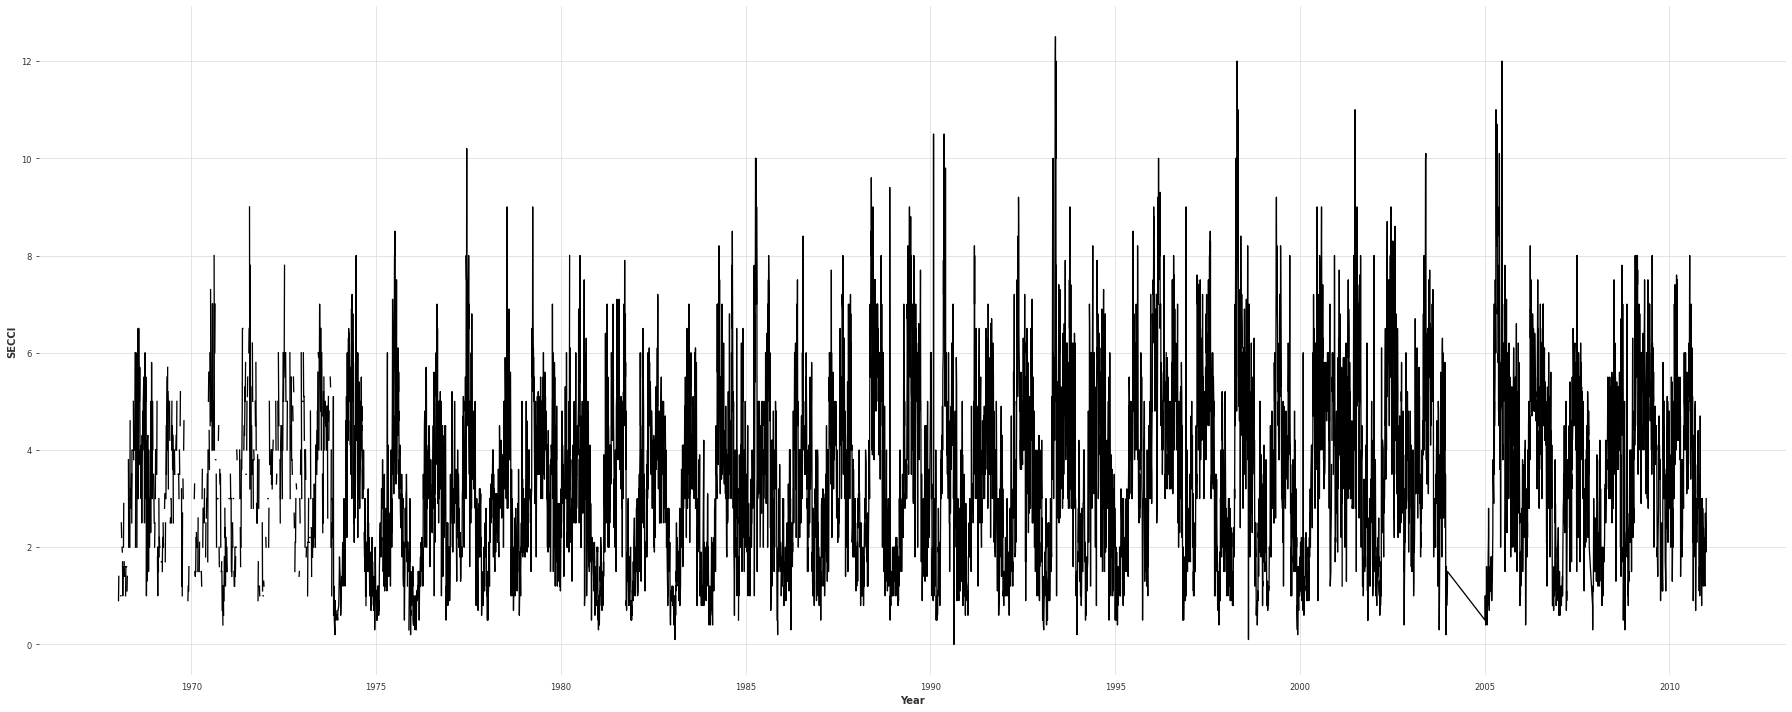

In [ ]:
plot_data('SECCI')

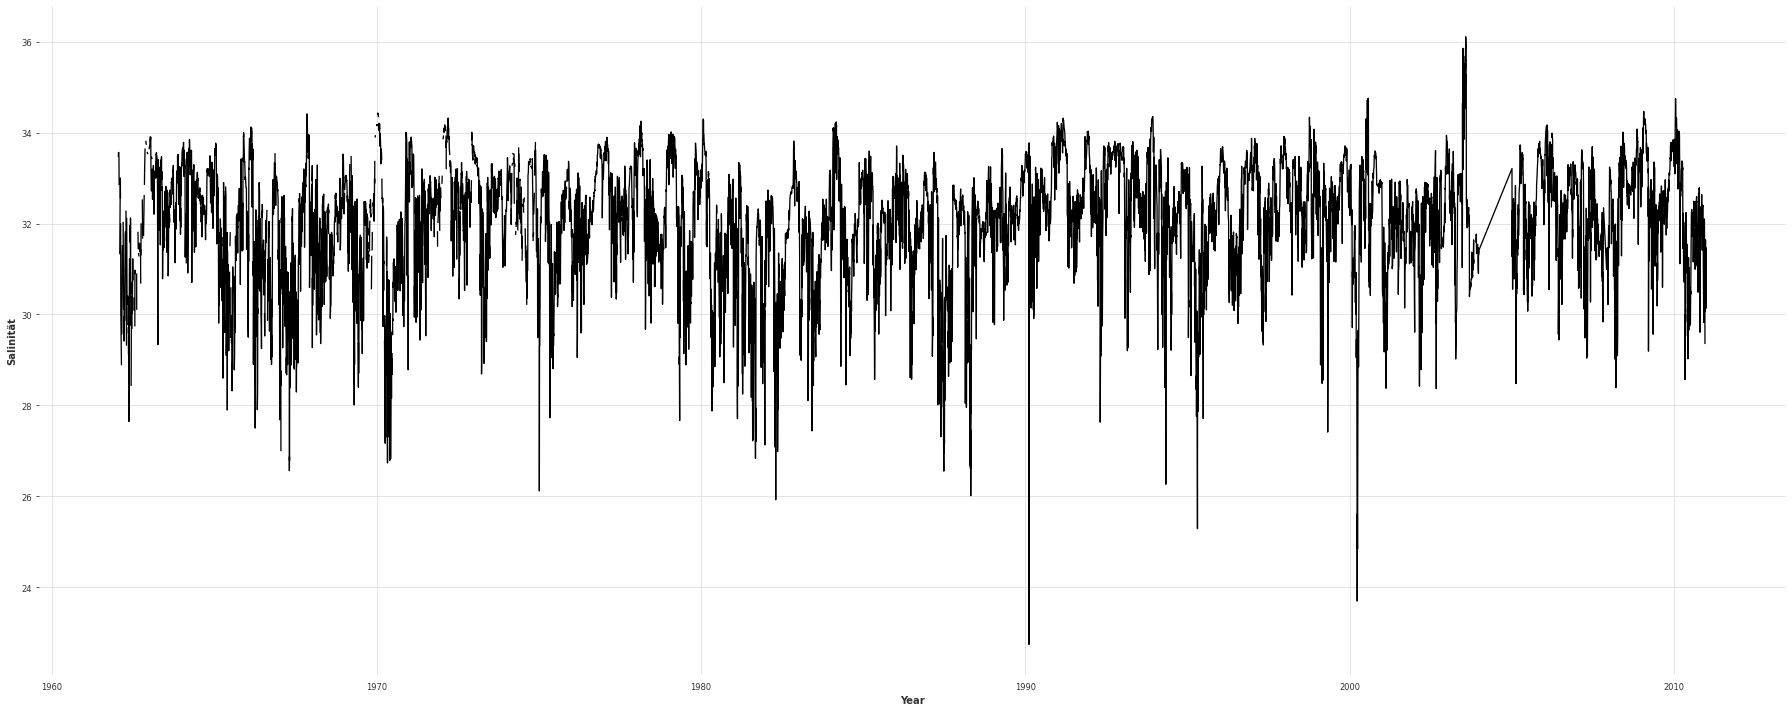

In [ ]:
plot_data('Salinität')

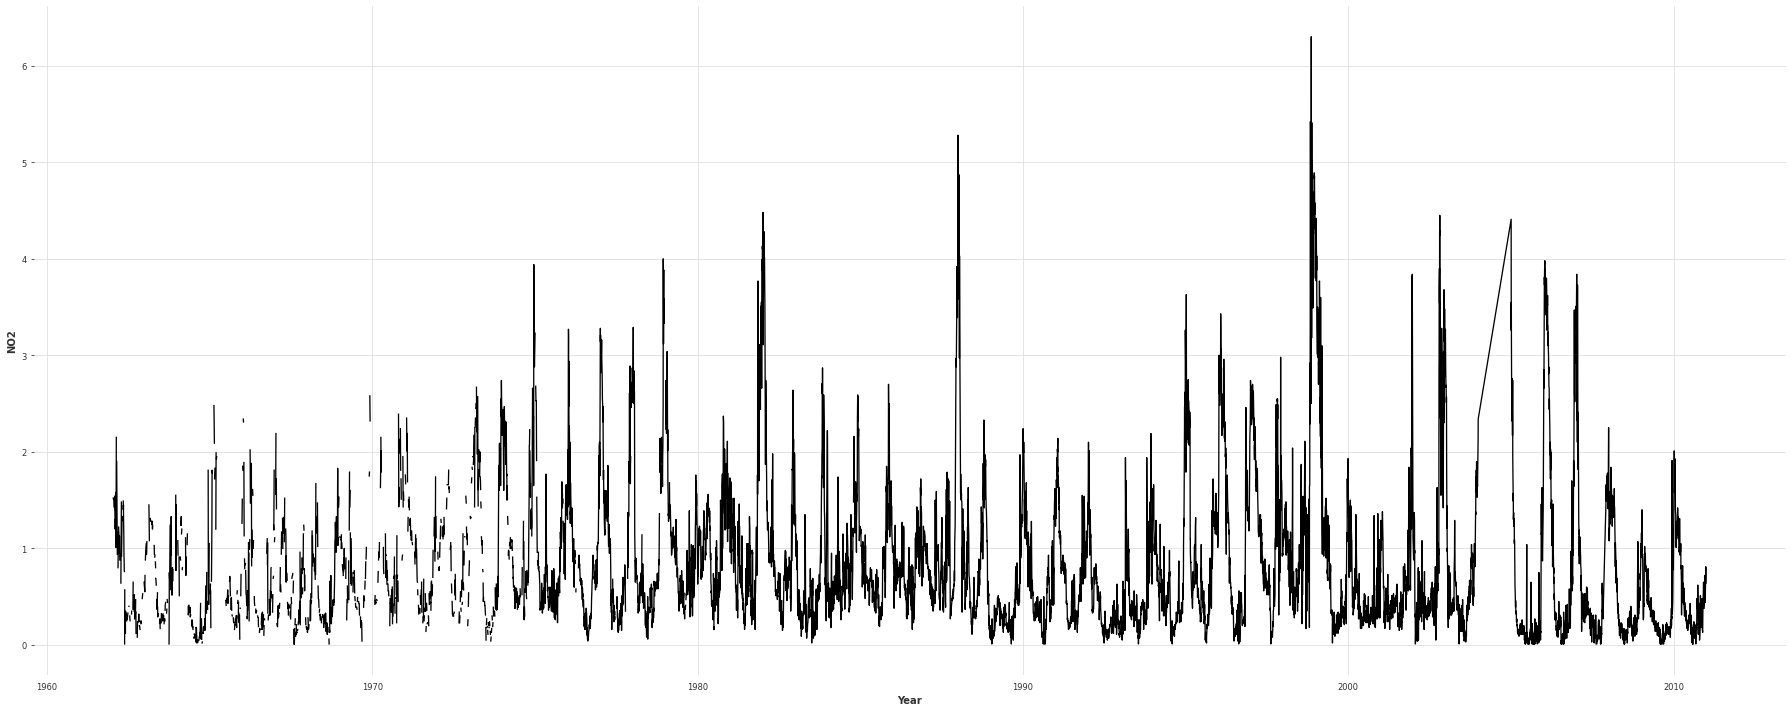

In [ ]:
plot_data('NO2')

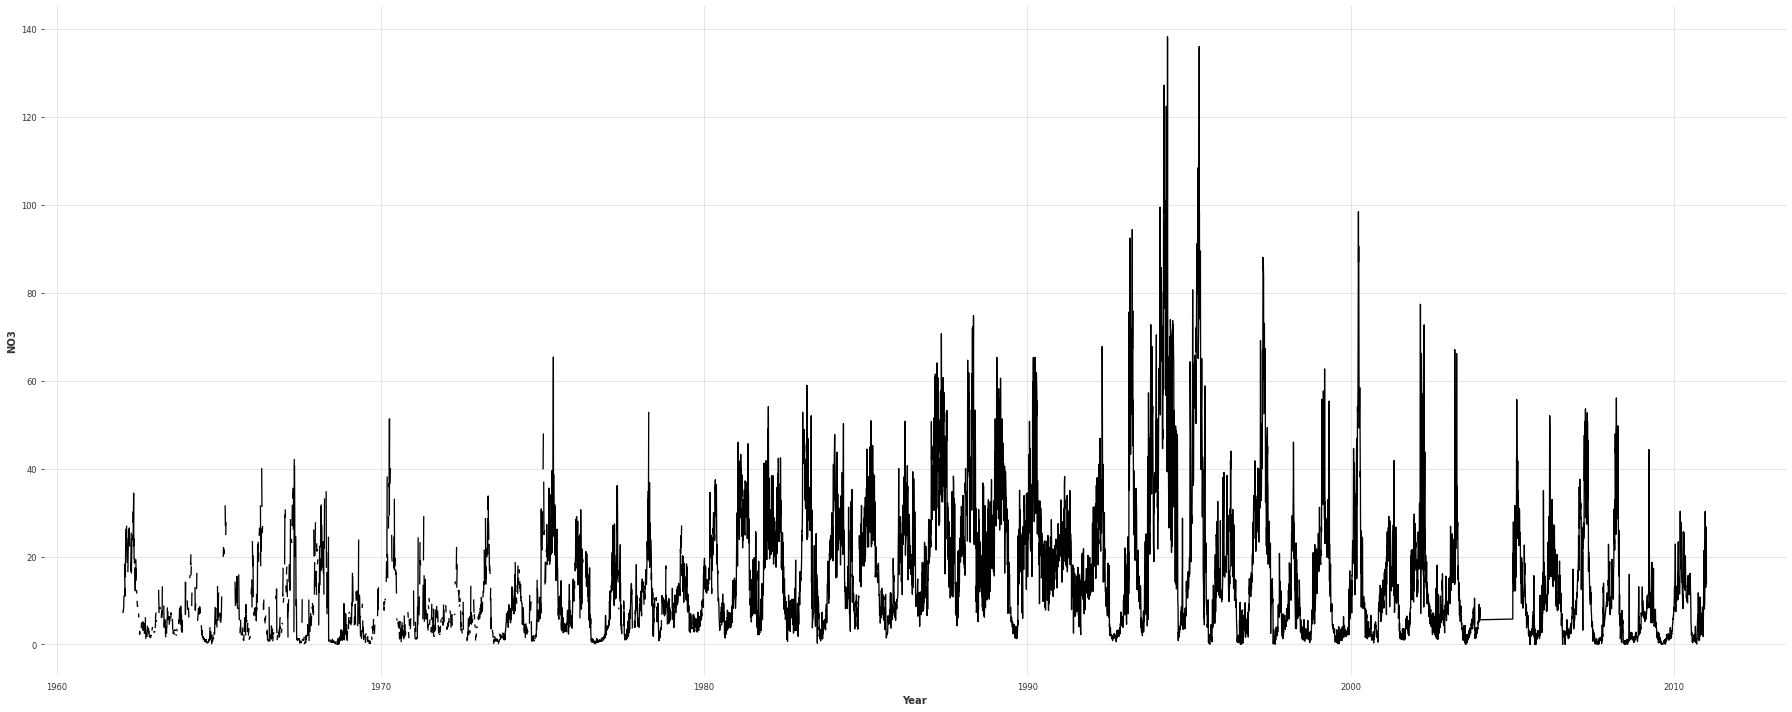

In [ ]:
plot_data('NO3')

In [ ]:
plot_data('NOx')

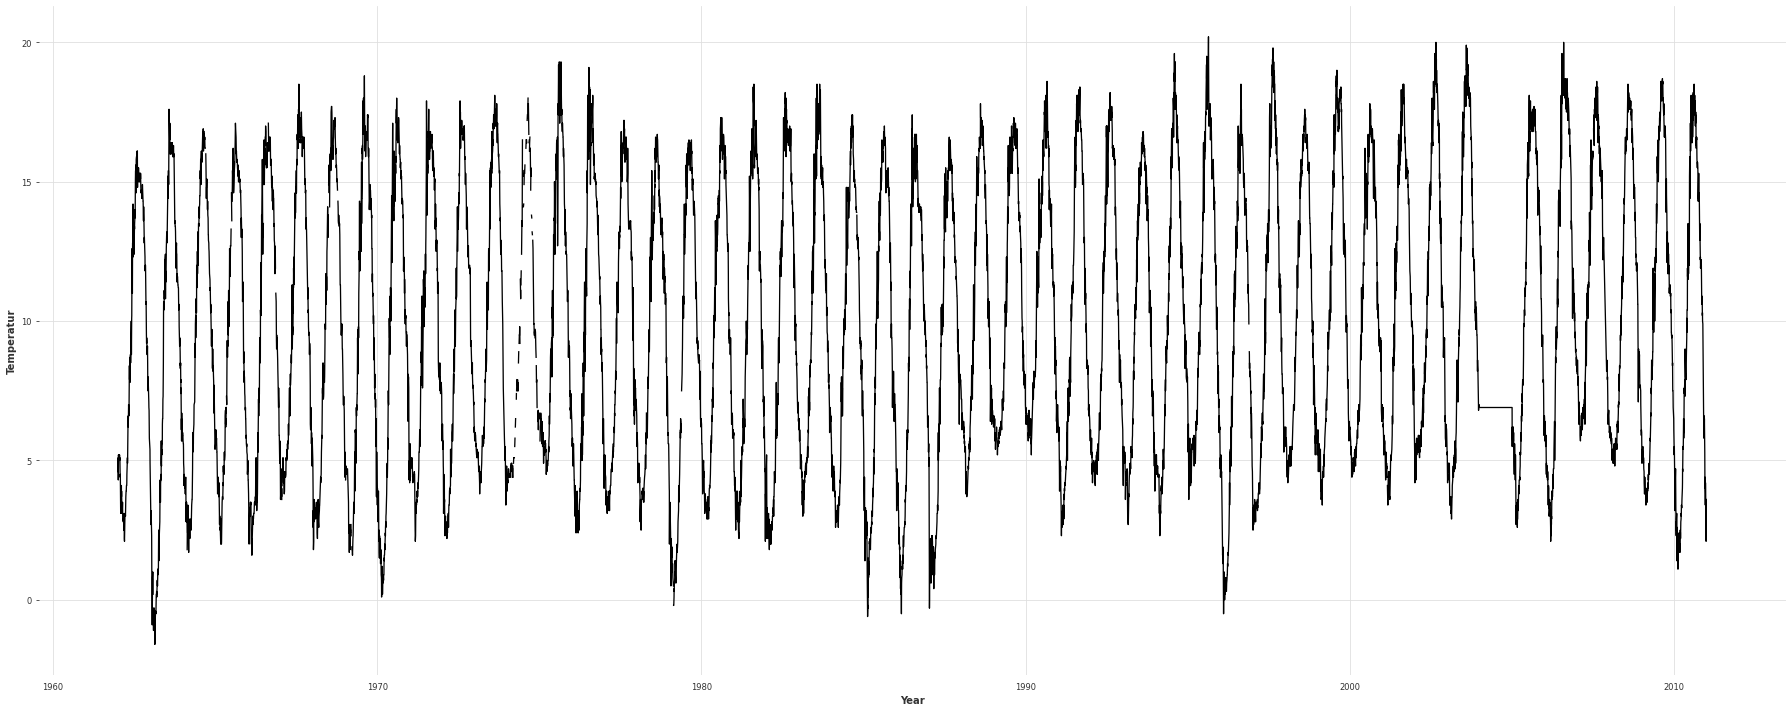

In [ ]:
plot_data('Temperatur')

## Merging Water (Flood) Data and Weather Data

In [ ]:
# number of seconds and number of days 
day = 24*60*60
year = (365.2425)*day

# add the sine and cosine columns to the dataframe
data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

data.head(-5)

**Subseting the data for the years 2005-2010**

In [ ]:
data_subset_05_10 = data.loc['2005-01-03 08:25:00':,:]

In [ ]:
data_subset_05_10.info()

In [ ]:
data_subset_05_10.dropna(axis=0, inplace=True)
data_subset_05_10.reset_index(inplace=True)
data_subset_05_10.drop(data_subset_05_10.columns[[0]], inplace=True, axis=1)

In [ ]:
data_subset_05_10.head(-5)

## Data Preparation

### Train, Validation and Test Data

In [ ]:
num_train_samples = int(0.8 * data_subset_05_10.shape[0])
num_val_samples = int(0.2 * data_subset_05_10.shape[0])


n = data_subset_05_10.shape[0]
train_df = data_subset_05_10[0:int(n*0.8)]
val_df = data_subset_05_10[int(n*0.8):]

train_label = train_df.drop(train_df.columns[[6,7,8,9]], axis=1)
train_label_secci = train_df.drop(train_df.columns[[1,2,3,4,5,6,7,8,9]], axis=1)
train_label_temp = train_df.drop(train_df.columns[[0,2,3,4,5,6,7,8,9]], axis=1)
train_label_salin = train_df.drop(train_df.columns[[0,1,3,4,5,6,7,8,9]], axis=1)
train_label_no2 = train_df.drop(train_df.columns[[0,1,2,4,5,6,7,8,9]], axis=1)
train_label_no3 = train_df.drop(train_df.columns[[0,1,2,3,5,6,7,8,9]], axis=1)
train_label_nox = train_df.drop(train_df.columns[[0,1,2,3,4,6,7,8,9]], axis=1)

train_input = train_df.loc[:,['Day sin', 'Day cos','Year sin', 'Year cos']]
#train_input = train_df.loc[:,['Year sin', 'Year cos']]

val_label = val_df.drop(val_df.columns[[6,7,8,9]], axis=1)
val_label_secci = val_df.drop(val_df.columns[[1,2,3,4,5,6,7,8,9]], axis=1)
val_label_temp = val_df.drop(val_df.columns[[0,2,3,4,5,6,7,8,9]], axis=1)
val_label_salin = val_df.drop(val_df.columns[[0,1,3,4,5,6,7,8,9]], axis=1)
val_label_no2 = val_df.drop(val_df.columns[[0,1,2,4,5,6,7,8,9]], axis=1)
val_label_no3 = val_df.drop(val_df.columns[[0,1,2,3,5,6,7,8,9]], axis=1)
val_label_nox = val_df.drop(val_df.columns[[0,1,2,3,4,6,7,8,9]], axis=1)

val_input = val_df.loc[:,['Day sin', 'Day cos','Year sin', 'Year cos']]
#val_input = val_df.loc[:,['Year sin', 'Year cos']]

mean = train_label.mean()
std = train_label.std()

data_subset_05_10_normalized = (data_subset_05_10 - mean) / std
train_label = (train_label - mean) / std
val_label = (val_label - mean) / std

#flood_data = (flood_data - mean_flood) / std_flood

In [ ]:
def standardise(df):
  mean = df.mean()
  std = df.std()

  df_stand = (df - mean) / std

  return mean, std, df_stand

In [ ]:
train_mean_secci, train_std_secci, train_label_secci = standardise(train_label_secci)
train_mean_temp, train_std_temp, train_label_temp = standardise(train_label_temp)
train_mean_salin, train_std_salin, train_label_salin = standardise(train_label_salin)
train_mean_no2, train_std_no2, train_label_no2 = standardise(train_label_no2)
train_mean_no3, train_std_no3, train_label_no3 = standardise(train_label_no3)
train_mean_nox, train_std_nox, train_label_nox = standardise(train_label_nox)

val_mean_secci, val_std_secci, val_label_secci = standardise(val_label_secci)
val_mean_temp, val_std_temp, val_label_temp = standardise(val_label_temp)
val_mean_salin, val_std_salin, val_label_salin = standardise(val_label_salin)
val_mean_no2, val_std_no2, val_label_no2 = standardise(val_label_no2)
val_mean_no3, val_std_no3, val_label_no3 = standardise(val_label_no3)
val_mean_nox, val_std_nox, val_label_nox = standardise(val_label_nox)

In [ ]:
train_df.info()

In [ ]:
train_input = train_input.astype('float32')
train_label = train_label.astype('float32')

train_label_secci = train_label_secci.astype('float32')
train_label_temp = train_label_temp.astype('float32')
train_label_salin = train_label_salin.astype('float32')
train_label_no2 = train_label_no2.astype('float32')
train_label_no3 = train_label_no3.astype('float32')
train_label_nox = train_label_nox.astype('float32')


val_input = val_input.astype('float32')
val_label = val_label.astype('float32')

val_label_secci = val_label_secci.astype('float32')
val_label_temp = val_label_temp.astype('float32')
val_label_salin = val_label_salin.astype('float32')
val_label_no2 = val_label_no2.astype('float32')
val_label_no3 = val_label_no3.astype('float32')
val_label_nox = val_label_nox.astype('float32')

In [ ]:
for i,j in train_dataset.take(1):
    print(i,j)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))

train_dataset_secci = tf.data.Dataset.from_tensor_slices((train_input, train_label_secci))
train_dataset_temp = tf.data.Dataset.from_tensor_slices((train_input, train_label_temp))
train_dataset_salin = tf.data.Dataset.from_tensor_slices((train_input, train_label_salin))
train_dataset_no2 = tf.data.Dataset.from_tensor_slices((train_input, train_label_no2))
train_dataset_no3 = tf.data.Dataset.from_tensor_slices((train_input, train_label_no3))
train_dataset_nox = tf.data.Dataset.from_tensor_slices((train_input, train_label_nox))


val_dataset_secci = tf.data.Dataset.from_tensor_slices((val_input, val_label_secci))
val_dataset_temp = tf.data.Dataset.from_tensor_slices((val_input, val_label_temp))
val_dataset_salin = tf.data.Dataset.from_tensor_slices((val_input, val_label_salin))
val_dataset_no2 = tf.data.Dataset.from_tensor_slices((val_input, val_label_no2))
val_dataset_no3 = tf.data.Dataset.from_tensor_slices((val_input, val_label_no3))
val_dataset_nox = tf.data.Dataset.from_tensor_slices((val_input, val_label_nox))


def preprocess(dataset):

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(20)

    return dataset

train_dataset = preprocess(train_dataset)
train_dataset_secci = preprocess(train_dataset_secci)
train_dataset_temp = preprocess(train_dataset_temp)
train_dataset_salin = preprocess(train_dataset_salin)
train_dataset_no2 = preprocess(train_dataset_no2)
train_dataset_no3 = preprocess(train_dataset_no3)
train_dataset_nox = preprocess(train_dataset_nox)




val_dataset   = preprocess(val_dataset)
val_dataset_secci = preprocess(val_dataset_secci)
val_dataset_temp = preprocess(val_dataset_temp)
val_dataset_salin = preprocess(val_dataset_salin)
val_dataset_no2 = preprocess(val_dataset_no2)
val_dataset_no3 = preprocess(val_dataset_no3)
val_dataset_nox = preprocess(val_dataset_nox)

In [ ]:
train_dataset

# Tensorflow Models

**Sechi model**

In [ ]:
# Get input, target dims
for batch in train_dataset_secci.take(1):
    inputs_secci, targets_secci = batch


inputs_model_secci = keras.Input(shape=(inputs_secci.shape[1]))
x_secci = layers.Dense(128, name='norm1',activation='tanh')(inputs_model_secci)
#x = layers.Dropout(0.2, name='norm2')(x)
x_secci = layers.Dense(64, name='norm3',activation='tanh')(x_secci)
#x = layers.Dropout(0.2, name='norm4')(x)
x_secci = layers.Dense(32, name='norm5',activation='tanh')(x_secci)
#x = layers.Dropout(0.2, name='norm6')(x)
x_secci = layers.Dense(16, name='norm7',activation='tanh')(x_secci)
outputs_secci = layers.Dense(1, name='norm8')(x_secci)
model_secci = keras.Model(inputs_model_secci, outputs_secci)

callbacks = [
    keras.callbacks.ModelCheckpoint('sechi_model.keras',
                                     save_best_only=True)
]

model_secci.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_custom = model_secci.fit(train_dataset_secci,
                    epochs=150,
                    validation_data=val_dataset_secci,
                    callbacks=callbacks)

model_secci = keras.models.load_model('sechi_model.keras')


**Temperature model**

**Salinity model**

**No2 model**

**No3 model**

**NoX model**

In [ ]:
# Get input, target dims
for batch in train_dataset_nox.take(1):
    inputs_nox, targets_nox = batch


inputs_model_nox = keras.Input(shape=(inputs_nox.shape[1]))
x_nox = layers.Dense(460, name='norm1',activation='tanh')(inputs_model_nox)
#x = layers.Dropout(0.2, name='norm2')(x)
x_nox = layers.Dense(240, name='norm3',activation='tanh')(x_nox)
#x = layers.Dropout(0.2, name='norm4')(x)
x_nox = layers.Dense(120, name='norm5',activation='tanh')(x_nox)
#x = layers.Dropout(0.2, name='norm6')(x)
x_nox = layers.Dense(60, name='norm7',activation='tanh')(x_nox)
x_nox = layers.Dense(32, name='norm8',activation='tanh')(x_nox)
x_nox = layers.Dense(16, name='norm9',activation='tanh')(x_nox)
outputs_nox = layers.Dense(1, name='norm10')(x_nox)
model_nox = keras.Model(inputs_model_nox, outputs_nox)

callbacks = [
    keras.callbacks.ModelCheckpoint('nox_model.keras',
                                     save_best_only=True)
]

model_nox.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_custom = model_nox.fit(train_dataset_secci,
                    epochs=150,
                    validation_data=val_dataset_secci,
                    callbacks=callbacks)

model_nox = keras.models.load_model('nox_model.keras')

## Simple Dense model

In [ ]:
# Get input, target dims
for batch in train_dataset.take(1):
    inputs, targets = batch


inputs_model = keras.Input(shape=(inputs.shape[1]))
x = layers.Dense(600, name='norm1',activation='tanh')(inputs_model)
x = layers.Dropout(0.2, name='norm2')(x)
x = layers.Dense(420, name='norm3',activation='tanh')(x)
x = layers.Dropout(0.2, name='norm4')(x)
x = layers.Dense(220, name='norm5',activation='tanh')(x)
x = layers.Dropout(0.2, name='norm6')(x)
x = layers.Dense(160, name='norm7',activation='tanh')(x)
x = layers.Dropout(0.2, name='norm8')(x)
x = layers.Dense(80, name='norm9',activation='tanh')(x)
x = layers.Dropout(0.2, name='norm10')(x)
x = layers.Dense(40, name='norm11',activation='tanh')(x)
x = layers.Dropout(0.2, name='norm12')(x)
x = layers.Dense(20, name='norm13',activation='tanh')(x)
x = layers.Dropout(0.2, name='norm14')(x)
outputs = layers.Dense(6, name='norm15')(x)
model = keras.Model(inputs_model, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('water_data.keras',
                                     save_best_only=True)
]

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_custom = model.fit(train_dataset,
                    epochs=400,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model('water_data.keras')
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

## Predicting the values for the provided dates

In [ ]:
to_predict = pd.read_csv('/content/bbdc_2023_AWI_data_evaluate_skeleton_student_empty.csv', delimiter=';')

to_predict_t = to_predict.tail(-1)


to_predict_t['date'] = pd.to_datetime(to_predict_t['Datum'] + ' ' + to_predict_t['Uhrzeit'], format="%d.%m.%Y %H:%M")
to_predict_t.set_index('date', inplace=True)

timestamp_to_predict = to_predict_t.index.map(pd.Timestamp.timestamp)


# add the sine and cosine columns to the dataframe
to_predict_t['Day sin'] = np.sin(timestamp_to_predict * (2 * np.pi / day))
to_predict_t['Day cos'] = np.cos(timestamp_to_predict * (2 * np.pi / day))
to_predict_t['Year sin'] = np.sin(timestamp_to_predict * (2 * np.pi / year))
to_predict_t['Year cos'] = np.cos(timestamp_to_predict * (2 * np.pi / year))

In [ ]:
to_predict.info()

In [ ]:
predict_input = to_predict_t.loc[:,['Day sin', 'Day cos','Year sin', 'Year cos']]
#predict_input = to_predict_t.loc[:,['Year sin', 'Year cos']]

In [ ]:
predictions = model.predict(predict_input)
predictions = np.insert(predictions, 0, [0,0,0,0,0,0],axis=0)
predictions_df = pd.DataFrame(predictions, columns = ['SECCI','Temperatur','Salinität','NO2', 'NO3', 'NOx'])

In [ ]:
predictions_nox = model_nox.predict(predict_input)
predictions_nox_df = pd.DataFrame(predictions_nox, columns = ['NOx'])

In [ ]:
predictions_nox_df = predictions_nox_df * train_std_nox + train_mean_nox

In [ ]:
predictions_nox_df

In [ ]:
predictions_df = predictions_df * std + mean

In [ ]:
to_predict.update(predictions_df, overwrite=False)

In [ ]:
to_predict

In [ ]:
to_predict.to_csv('bbdc_2023_AWI_data_evaluate_skeleton_student.csv', index=False, sep=';')

In [ ]:
from google.colab import files
files.download('bbdc_2023_AWI_data_evaluate_skeleton_student.csv')

# Preparing and Exploring data for Darts models

In [ ]:
darts_data = pd.read_csv('/content/bbdc_2023_AWI_data_develop_student.csv', delimiter=';')

darts_data.dropna(axis=0, inplace=True, subset=['Uhrzeit'])
darts_data.drop(darts_data.columns[[7]], inplace=True, axis=1)
darts_data.dropna(axis=0, inplace=True)

# creating a date column for timestamps
darts_data['date'] = pd.to_datetime(darts_data['Datum'] + ' ' +  darts_data['Uhrzeit'], format="%d.%m.%Y %H:%M")

# drop the rows without a time given, since there were no measurements taken


# set the date column as the index and create the timestamps
darts_data.set_index('date', inplace=True)
darts_data = darts_data.loc['1970-01-03':]
timestamp_s = darts_data.index.map(pd.Timestamp.timestamp)

darts_data.reset_index(inplace=True)
darts_data['Datum'] = pd.to_datetime(darts_data['Datum'], format="%d.%m.%Y")
# drop the Datum Uhrzeit and NOx columns
darts_data.drop(darts_data.columns[[2]], inplace=True, axis=1)
#darts_data = darts_data.astype('float32')
darts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8901 entries, 0 to 8900
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        8901 non-null   datetime64[ns]
 1   Datum       8901 non-null   datetime64[ns]
 2   SECCI       8901 non-null   object        
 3   Temperatur  8901 non-null   object        
 4   Salinität   8901 non-null   float64       
 5   NO2         8901 non-null   object        
 6   NO3         8901 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 486.9+ KB


In [ ]:
darts_data

,date,Datum,SECCI,Temperatur,Salinität,NO2,NO3
0,1970-02-06 09:35:00,1970-02-06,1.5,1.3,33.706,0.46,9.57
1,1970-02-09 10:10:00,1970-02-09,1.4,1.8,33.976,0.43,7.78
2,1970-02-13 09:35:00,1970-02-13,1.5,0.9,33.850,0.44,9.28
3,1970-02-16 09:00:00,1970-02-16,2.2,0.8,33.709,0.44,9.78
4,1970-02-20 09:30:00,1970-02-20,2.3,0.8,33.637,0.47,10.28
...,...,...,...,...,...,...,...
8896,2010-12-21 09:25:00,2010-12-21,2.6,4.0,30.861,0.52,18.85
8897,2010-12-22 08:15:00,2010-12-22,2.7,4.2,31.643,0.44,12.98
8898,2010-12-28 08:30:00,2010-12-28,1.9,2.9,30.137,0.81,26.1
8899,2010-12-29 08:15:00,2010-12-29,2.0,2.1,30.273,0.79,26.73


In [ ]:
darts_data.set_index('date', inplace=True)
new_data = darts_data.groupby([darts_data.index.month, darts_data.index.day]).first()

In [ ]:
subset_for_04 = darts_data.loc['1999-01-02':'2005-12-30']
subset_for_04.drop(subset_for_04.columns[[0]], inplace=True, axis=1)
subset_for_04 = subset_for_04.astype('float32')

<ipython-input-118-e1446e8e3b9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_for_04.drop(subset_for_04.columns[[0]], inplace=True, axis=1)


In [ ]:
subset_for_11 = darts_data.loc['2006-01-02':'2010-12-30']
subset_for_11.drop(subset_for_11.columns[[0]], inplace=True, axis=1)
subset_for_11 = subset_for_11.astype('float32')

<ipython-input-152-1e5e7d4953ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_for_11.drop(subset_for_11.columns[[0]], inplace=True, axis=1)


In [ ]:
subset_for_12 = darts_data.loc['2006-01-02':'2010-12-30']
subset_for_12.drop(subset_for_12.columns[[0]], inplace=True, axis=1)
subset_for_12 = subset_for_12.astype('float32')

<ipython-input-153-ebe90aebdf63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_for_12.drop(subset_for_12.columns[[0]], inplace=True, axis=1)


In [ ]:
subset_for_13 = darts_data.loc['2006-01-02':'2010-12-30']
subset_for_13.drop(subset_for_13.columns[[0]], inplace=True, axis=1)
subset_for_13 = subset_for_13.astype('float32')

<ipython-input-154-fa1d5db75918>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_for_13.drop(subset_for_13.columns[[0]], inplace=True, axis=1)


In [ ]:
data_for_04 = subset_for_04.groupby([subset_for_04.index.month, subset_for_04.index.day]).mean()

In [ ]:
 data_for_11 = subset_for_11.groupby([subset_for_11.index.month, subset_for_11.index.day]).mean()

In [ ]:
 data_for_12 = subset_for_12.groupby([subset_for_12.index.month, subset_for_12.index.day]).mean()

In [ ]:
 data_for_13 = subset_for_13.groupby([subset_for_13.index.month, subset_for_13.index.day]).mean()

In [ ]:
data_for_04['month_day'] = data_for_04.index
data_for_11['month_day'] = data_for_11.index
data_for_12['month_day'] = data_for_12.index
data_for_13['month_day'] = data_for_13.index

In [ ]:
final_predictions = pd.read_csv('/content/bbdc_2023_AWI_data_evaluate_skeleton_student_empty.csv', delimiter=';')
prediction_dates = pd.read_csv('/content/bbdc_2023_AWI_data_evaluate_skeleton_student_empty.csv', delimiter=';')
prediction_dates = prediction_dates.tail(-1)
prediction_dates['date'] = pd.to_datetime(prediction_dates['Datum'] + ' ' +  prediction_dates['Uhrzeit'], format="%d.%m.%Y %H:%M")

prediction_dates.set_index('date', inplace=True)
timestamp = prediction_dates.index.map(pd.Timestamp.timestamp)

In [ ]:
prediction_dates_04 = prediction_dates.loc['2004-01-02':'2004-12-30']
prediction_dates_11 = prediction_dates.loc['2011-01-02':'2011-12-30']
prediction_dates_12 = prediction_dates.loc['2012-01-02':'2012-12-30']
prediction_dates_13 = prediction_dates.loc['2013-01-02':'2013-12-30']

In [ ]:
prediction_dates_04['month_day'] = prediction_dates_04.index.map(lambda x: (x.month, x.day))
prediction_dates_11['month_day'] = prediction_dates_11.index.map(lambda x: (x.month, x.day))
prediction_dates_12['month_day'] = prediction_dates_12.index.map(lambda x: (x.month, x.day))
prediction_dates_13['month_day'] = prediction_dates_13.index.map(lambda x: (x.month, x.day))

<ipython-input-163-70677d6a08c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_dates_04['month_day'] = prediction_dates_04.index.map(lambda x: (x.month, x.day))
<ipython-input-163-70677d6a08c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_dates_11['month_day'] = prediction_dates_11.index.map(lambda x: (x.month, x.day))
<ipython-input-163-70677d6a08c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [ ]:
prediction_dates_04.drop(prediction_dates_04.columns[[2,3,4,5,6,7]], inplace=True, axis=1)
prediction_dates_11.drop(prediction_dates_11.columns[[2,3,4,5,6,7]], inplace=True, axis=1)
prediction_dates_12.drop(prediction_dates_12.columns[[2,3,4,5,6,7]], inplace=True, axis=1)
prediction_dates_13.drop(prediction_dates_13.columns[[2,3,4,5,6,7]], inplace=True, axis=1)

<ipython-input-164-11234195946f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_dates_04.drop(prediction_dates_04.columns[[2,3,4,5,6,7]], inplace=True, axis=1)
<ipython-input-164-11234195946f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_dates_11.drop(prediction_dates_11.columns[[2,3,4,5,6,7]], inplace=True, axis=1)
<ipython-input-164-11234195946f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_

In [ ]:
final_predict_04 = pd.merge(prediction_dates_04, data_for_04, how="inner", left_on='month_day', right_on='month_day')
final_predict_11 = pd.merge(prediction_dates_11, data_for_11, how="inner", left_on='month_day', right_on='month_day')
final_predict_12 = pd.merge(prediction_dates_12, data_for_12, how="inner", left_on='month_day', right_on='month_day')
final_predict_13 = pd.merge(prediction_dates_13, data_for_13, how="inner", left_on='month_day', right_on='month_day')

In [ ]:
final_predict_04['NOx'] = final_predict_04['NO2'] + final_predict_04['NO3']
final_predict_11['NOx'] = final_predict_11['NO2'] + final_predict_11['NO3']
final_predict_12['NOx'] = final_predict_12['NO2'] + final_predict_12['NO3']
final_predict_13['NOx'] = final_predict_13['NO2'] + final_predict_13['NO3']

In [ ]:
final_predict_04.drop(final_predict_04.columns[[2]], inplace=True, axis=1)
final_predict_11.drop(final_predict_11.columns[[2]], inplace=True, axis=1)
final_predict_12.drop(final_predict_12.columns[[2]], inplace=True, axis=1)
final_predict_13.drop(final_predict_13.columns[[2]], inplace=True, axis=1)

In [ ]:
final_predict_11

,Datum,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,03.01.2011,9:10,2.020000,6.620000,32.915401,2.982000,11.212000,14.194000
1,04.01.2011,9:20,1.433333,6.733333,32.284668,3.176667,16.160000,19.336666
2,05.01.2011,8:25,1.333333,6.866667,32.612335,3.266667,15.953334,19.220001
3,06.01.2011,8:35,1.466667,5.366667,32.786667,2.786667,11.906667,14.693334
4,07.01.2011,9:10,2.350000,5.150000,33.445999,1.840000,8.325001,10.165001
...,...,...,...,...,...,...,...,...
225,22.12.2011,9:15,1.400000,7.775000,32.625000,1.572500,9.812500,11.385000
226,23.12.2011,9:11,1.566667,7.266667,32.132999,1.110000,7.636667,8.746667
227,28.12.2011,8:48,1.666667,7.033333,32.228333,1.896667,13.150000,15.046666
228,29.12.2011,8:40,2.375000,6.900000,32.462749,1.990000,10.142500,12.132500


In [ ]:
data = {'Datum': [0], 'Uhrzeit': [0], 'SECCI': [0], 'Temperatur': [0],'Salinität': [0], 'NO2': [0], 'NO3': [0], 'NOx': [0]}
substitute = pd.DataFrame(data=data)

In [ ]:
prefinal_frame = pd.concat([final_predict_04, final_predict_11, final_predict_12, final_predict_13], ignore_index=True, axis=0).round(3)
final_frame = pd.concat([substitute, prefinal_frame],ignore_index=True, axis=0)

<Axes: >

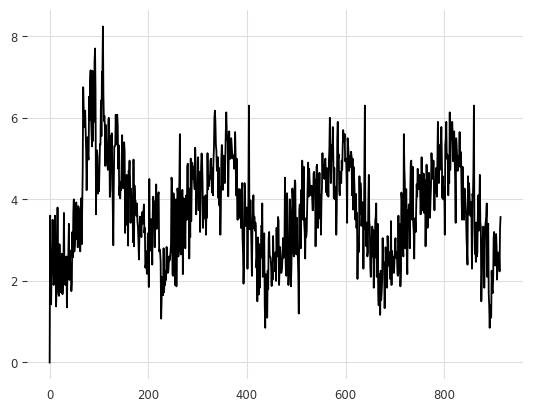

In [ ]:
final_frame['SECCI'].plot()

In [ ]:
final_predictions.update(final_frame, overwrite=False)
final_predictions.to_csv('bbdc_2023_AWI_data_evaluate_skeleton_student.csv', index=False, sep=';')

In [ ]:
from google.colab import files
files.download('bbdc_2023_AWI_data_evaluate_skeleton_student.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Preparing additional weather data from Helgoland**

In [ ]:
def read_csv_weather(file):
    df = pd.read_csv(file, delimiter=';')
    df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format="%Y%m%d")
    df.set_index('MESS_DATUM', inplace=True)
    timestamp_s = df.index.map(pd.Timestamp.timestamp)
    df.reset_index(inplace=True)
    df = df.replace(-999, pd.NA)
    
    return df

In [ ]:
helgoland_weather = read_csv_weather('/content/produkt_klima_tag_19520501_20211231_02115.txt')
helgoland_weather.drop(helgoland_weather.columns[[1,18]], inplace=True, axis=1)

helgoland_weather = helgoland_weather.fillna(helgoland_weather.mean())

#helgoland_weather.drop(helgoland_weather.columns[[1,2,4]], inplace=True, axis=1)
helgoland_weather.drop(helgoland_weather.columns[[1,2,3,4,6,8,9,10,13,15,16]], inplace=True, axis=1)
helgoland_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25427 entries, 0 to 25426
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   MESS_DATUM  25427 non-null  datetime64[ns]
 1    RSK        25427 non-null  float64       
 2    SDK        25427 non-null  float64       
 3     PM        25427 non-null  float64       
 4    TMK        25427 non-null  float64       
 5    TXK        25427 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.2 MB


<ipython-input-57-1bec6f6ef9c3>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  helgoland_weather = helgoland_weather.fillna(helgoland_weather.mean())


**Merge Data with Helgoland weather data**

In [ ]:
darts_data.reset_index(inplace=True)
darts_data_helgo = pd.merge(darts_data, helgoland_weather, how="inner", left_on='Datum', right_on='MESS_DATUM')
darts_data_helgo.set_index('date', inplace=True)
darts_data.set_index('date', inplace=True)
darts_data.drop(darts_data.columns[[0]], inplace=True, axis=1)

In [ ]:
darts_data_helgo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8901 entries, 1970-02-06 09:35:00 to 2010-12-30 08:30:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Datum       8901 non-null   datetime64[ns]
 1   SECCI       8901 non-null   object        
 2   Temperatur  8901 non-null   object        
 3   Salinität   8901 non-null   float64       
 4   NO2         8901 non-null   object        
 5   NO3         8901 non-null   object        
 6   MESS_DATUM  8901 non-null   datetime64[ns]
 7    RSK        8901 non-null   float64       
 8    SDK        8901 non-null   float64       
 9     PM        8901 non-null   float64       
 10   TMK        8901 non-null   float64       
 11   TXK        8901 non-null   float64       
dtypes: datetime64[ns](2), float64(6), object(4)
memory usage: 904.0+ KB


In [ ]:
darts_data_helgo.drop(darts_data_helgo.columns[[0,6]], inplace=True, axis=1)

In [ ]:
darts_data_helgo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8901 entries, 1970-02-06 09:35:00 to 2010-12-30 08:30:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SECCI       8901 non-null   object 
 1   Temperatur  8901 non-null   object 
 2   Salinität   8901 non-null   float64
 3   NO2         8901 non-null   object 
 4   NO3         8901 non-null   object 
 5    RSK        8901 non-null   float64
 6    SDK        8901 non-null   float64
 7     PM        8901 non-null   float64
 8    TMK        8901 non-null   float64
 9    TXK        8901 non-null   float64
dtypes: float64(6), object(4)
memory usage: 764.9+ KB


# Exploratory Data Analysis

**Heatmap of correlation**

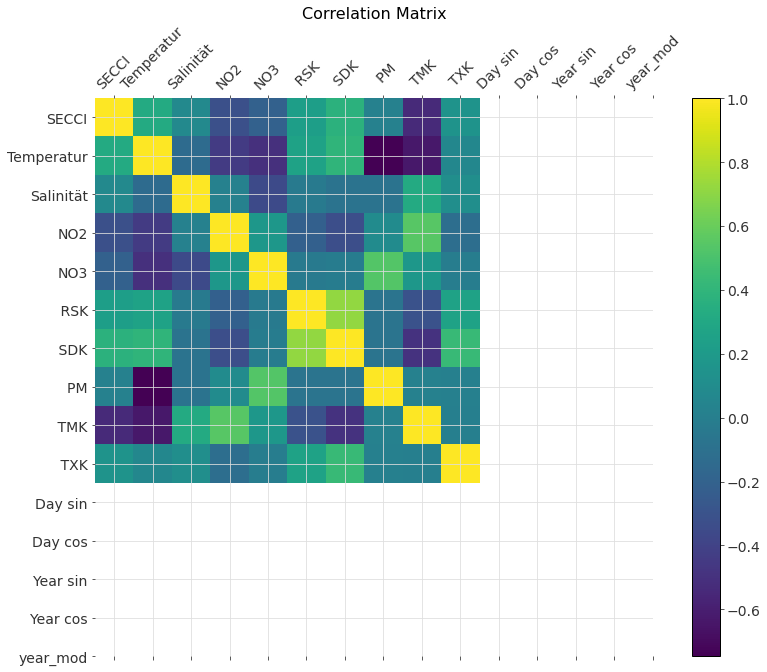

In [ ]:
f = plt.figure(figsize=(14, 10))
plt.matshow(darts_data.corr(), fignum=f.number)
plt.xticks(range(darts_data_helgo.select_dtypes(['number']).shape[1]), darts_data_helgo.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(darts_data_helgo.select_dtypes(['number']).shape[1]), darts_data_helgo.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**Visualising parameters for selected years**

In [ ]:
subset_data_plot = darts_data.loc['2008-01-03':]

In [ ]:
#function to plot the data
def plot_data(data, column = None):
  fig, ax = plt.subplots(figsize=(25,10))
  ax.plot(data.index, data[column])


  ax.legend()
  ax.set_xlabel('Year')
  ax.set_ylabel(column)

  fig.tight_layout()

**Sechi plot**

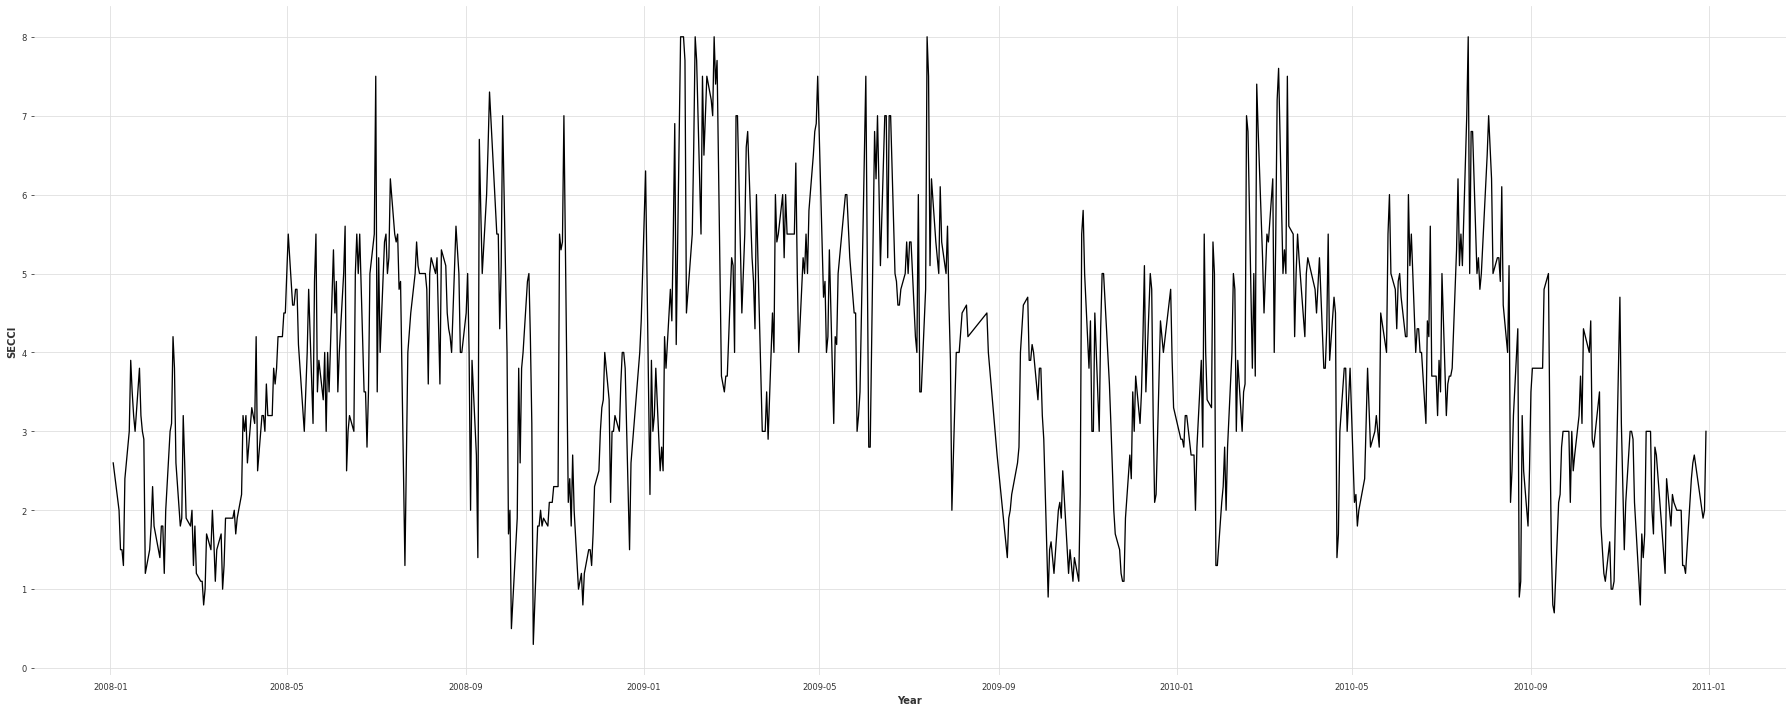

In [ ]:
plot_data(subset_data_plot, 'SECCI')

**Temperatur plot**

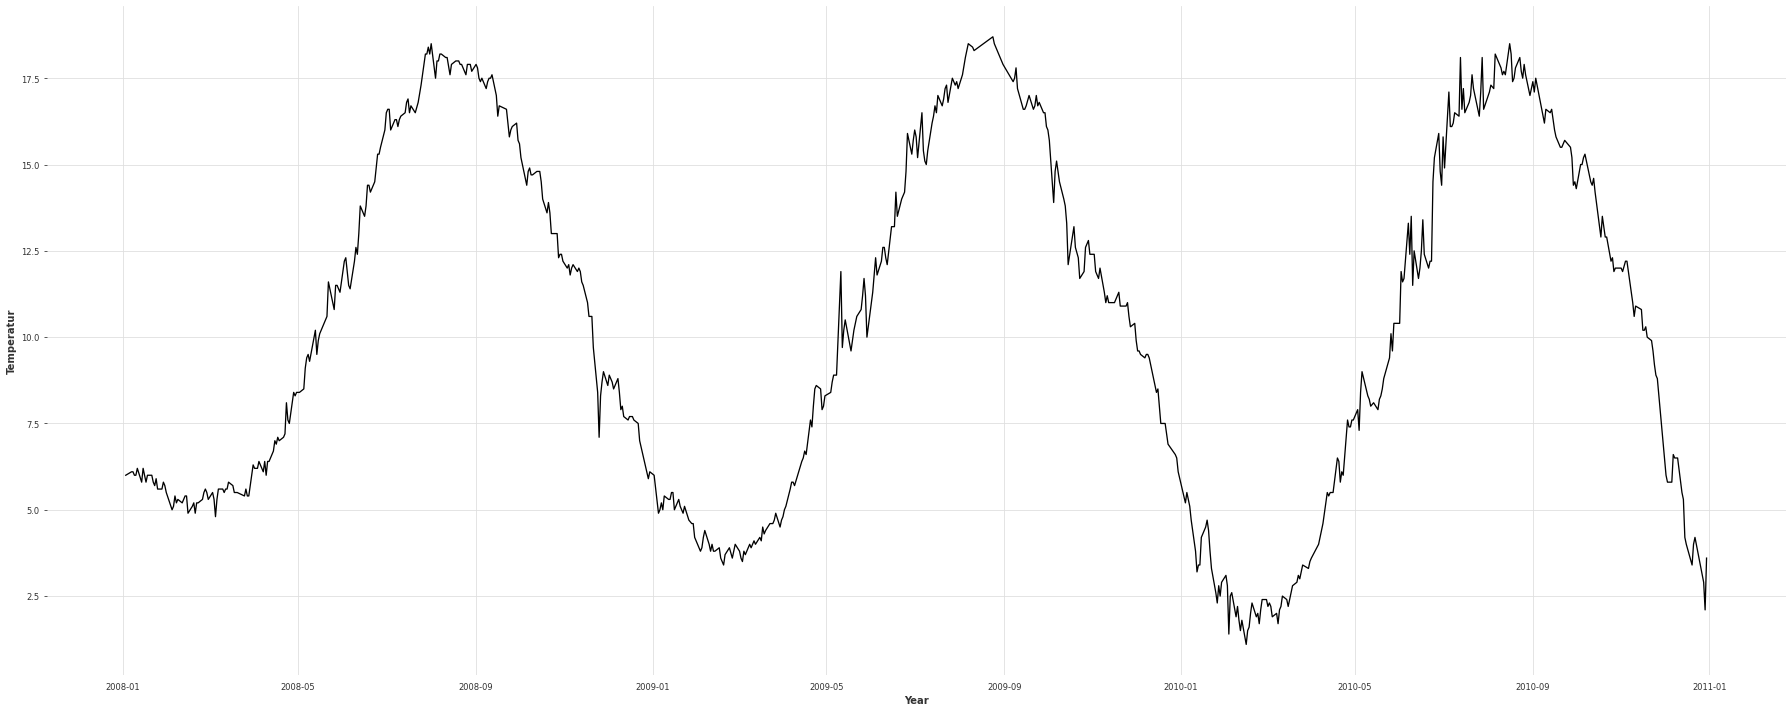

In [ ]:
plot_data(subset_data_plot, 'Temperatur')

**Salinität plot**

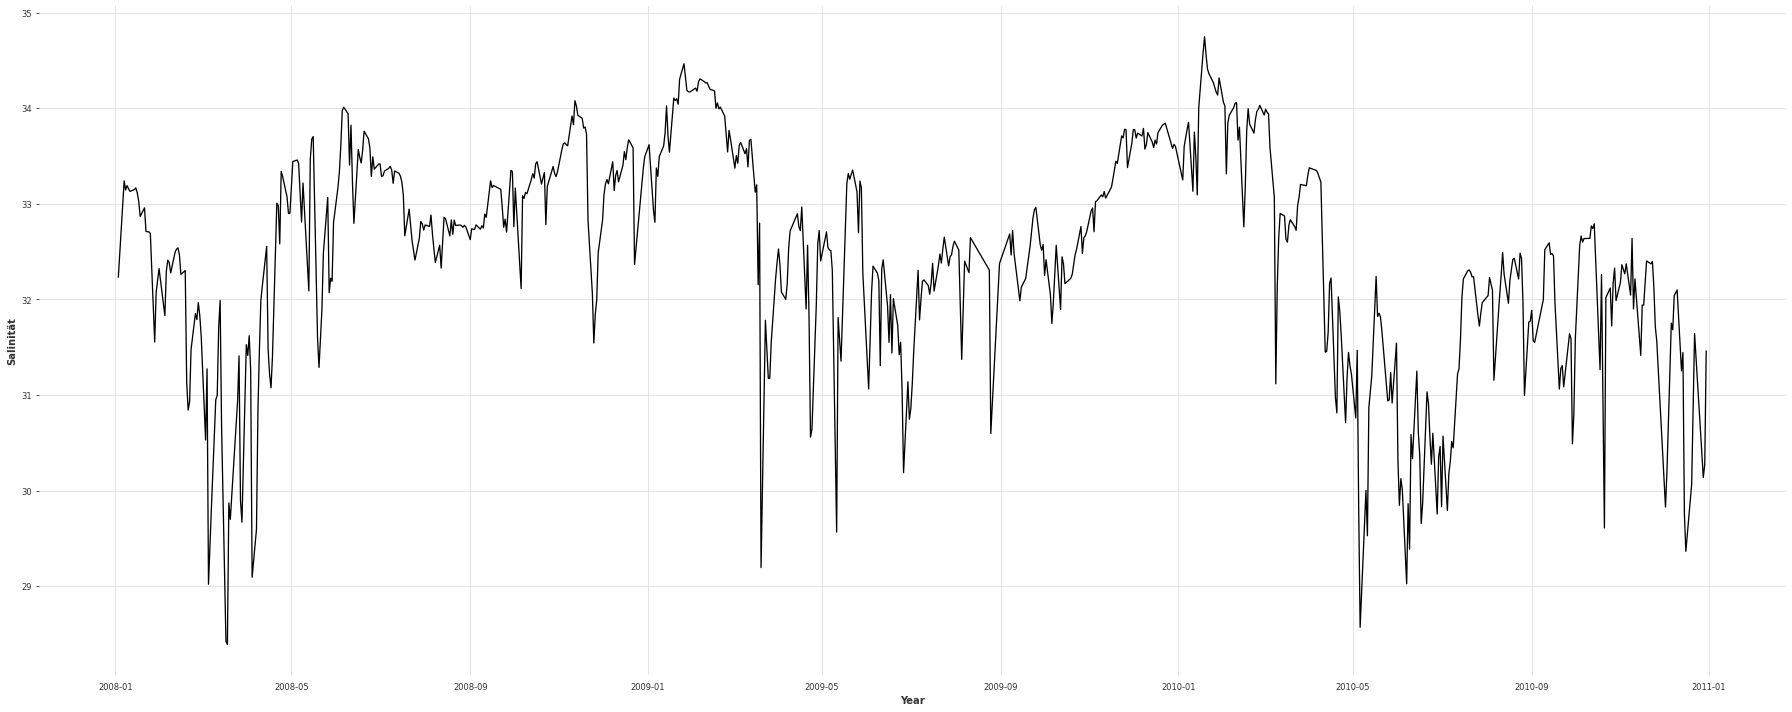

In [ ]:
plot_data(subset_data_plot, 'Salinität')

**NO2 plot**

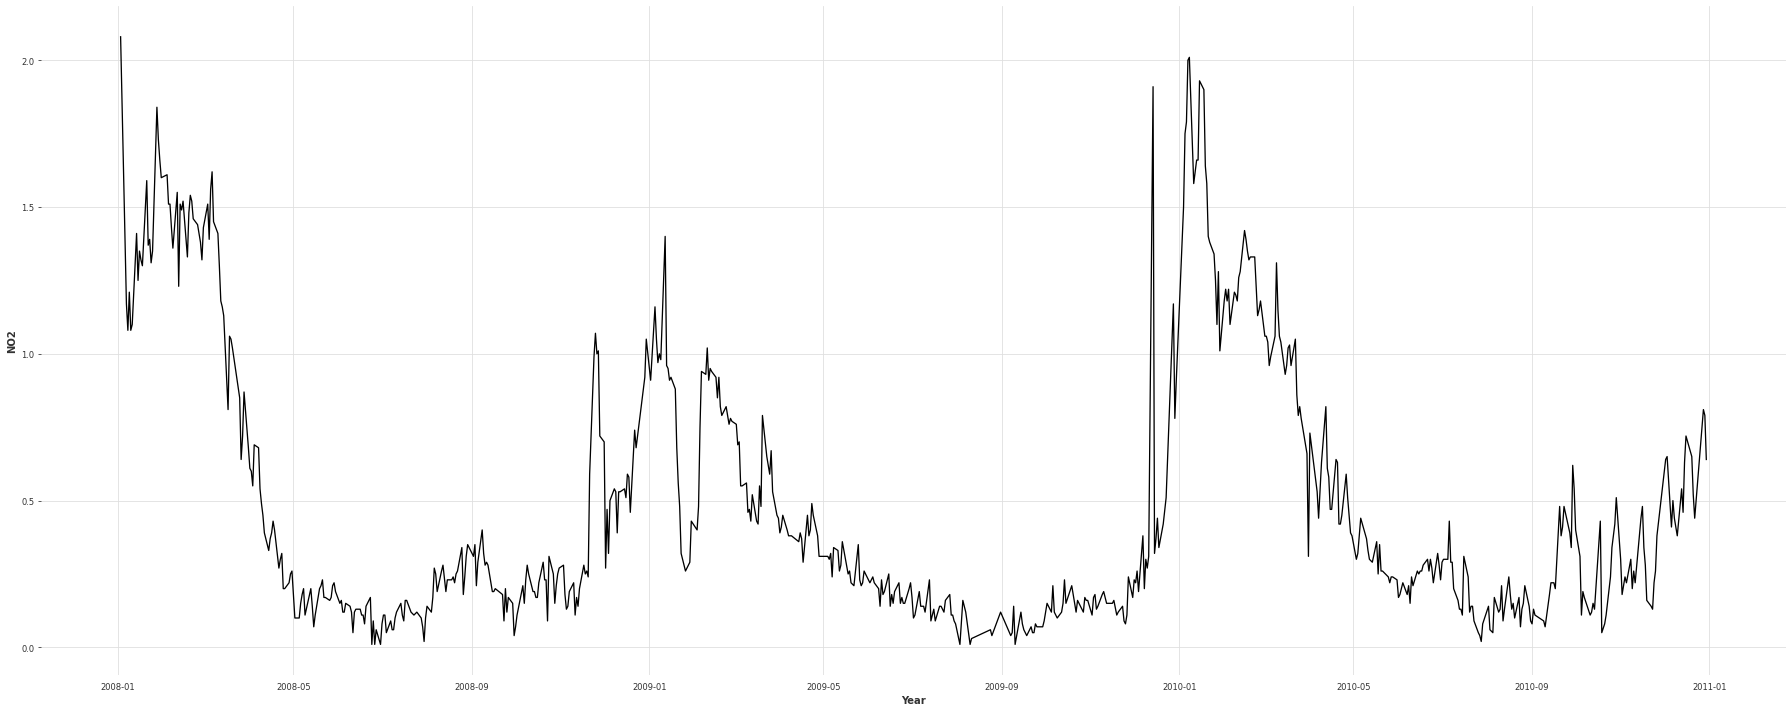

In [ ]:
plot_data(subset_data_plot, 'NO2')

**NO3 plot**

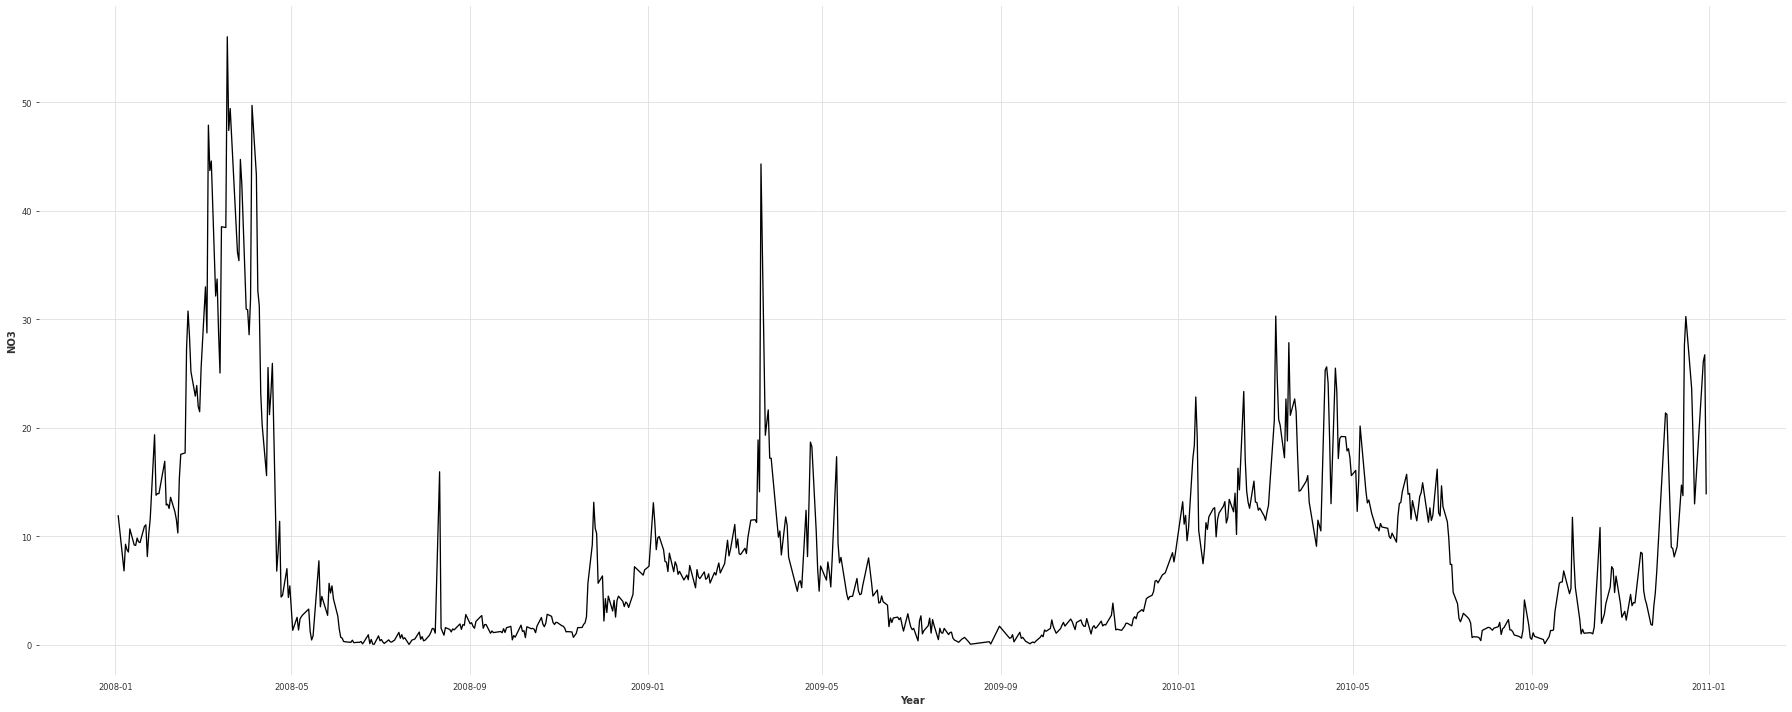

In [ ]:
plot_data(subset_data_plot, 'NO3')

In [ ]:
# to better understand the correlation heatmap above
corr = darts_data_helgo.corr()
corr.style.background_gradient(cmap='RdBu_r').set_precision(3)

<ipython-input-72-db7012ded225>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='RdBu_r').set_precision(3)


,SECCI,Temperatur,Salinität,NO2,NO3,RSK,SDK,PM,TMK,TXK,Day sin,Day cos,Year sin,Year cos,year_mod
SECCI,1.000,0.318,0.078,-0.320,-0.208,-0.059,0.320,0.083,0.407,0.425,0.232,0.373,0.024,-0.535,0.153
Temperatur,0.318,1.000,-0.139,-0.442,-0.504,0.092,0.301,0.025,0.918,0.903,0.259,0.396,-0.747,-0.636,0.065
Salinität,0.078,-0.139,1.000,0.019,-0.357,0.055,-0.227,-0.105,-0.188,-0.199,-0.029,-0.081,-0.082,0.321,0.114
NO2,-0.320,-0.442,0.019,1.000,0.179,-0.008,-0.297,-0.011,-0.495,-0.496,-0.212,-0.328,0.096,0.544,-0.118
NO3,-0.208,-0.504,-0.357,0.179,1.000,-0.077,-0.033,0.028,-0.411,-0.399,-0.035,-0.016,0.533,0.180,-0.009
RSK,-0.059,0.092,0.055,-0.008,-0.077,1.000,-0.247,-0.382,0.062,0.057,-0.007,-0.003,-0.131,0.015,0.011
SDK,0.320,0.301,-0.227,-0.297,-0.033,-0.247,1.000,0.261,0.421,0.462,0.172,0.292,0.087,-0.560,0.014
PM,0.083,0.025,-0.105,-0.011,0.028,-0.382,0.261,1.000,0.005,0.006,0.030,0.030,0.007,-0.052,-0.021
TMK,0.407,0.918,-0.188,-0.495,-0.411,0.062,0.421,0.005,1.000,0.990,0.292,0.448,-0.520,-0.761,0.055
TXK,0.425,0.903,-0.199,-0.496,-0.399,0.057,0.462,0.006,0.990,1.000,0.294,0.456,-0.486,-0.778,0.060


# Back to Tensorflow again

In [ ]:
 def add_time_features(data):
  day = 24*60*60
  year = (365.2425)*day


  data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
  data['year'] = data.index.year
  data['year_mod'] = (data['year'] - data['year'].min()) / (2013 - data['year'].min())
  data.drop(columns=['year'], inplace=True, axis=1)
  data = data.astype('float32')
  return data

In [ ]:
darts_data = add_time_features(darts_data)

In [ ]:
darts_data_helgo = add_time_features(darts_data_helgo)

In [ ]:
# for experimenting with the data 
#darts_data_helgo = darts_data_helgo.loc['1990-01-03':]

In [ ]:
darts_data_helgo.reset_index(inplace=True)

In [ ]:
darts_data_helgo.drop(columns=['date'], inplace=True, axis=1)

In [ ]:
darts_data_helgo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8901 entries, 0 to 8900
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SECCI       8901 non-null   float32
 1   Temperatur  8901 non-null   float32
 2   Salinität   8901 non-null   float32
 3   NO2         8901 non-null   float32
 4   NO3         8901 non-null   float32
 5    RSK        8901 non-null   float32
 6    SDK        8901 non-null   float32
 7     PM        8901 non-null   float32
 8    TMK        8901 non-null   float32
 9    TXK        8901 non-null   float32
 10  Day sin     8901 non-null   float32
 11  Day cos     8901 non-null   float32
 12  Year sin    8901 non-null   float32
 13  Year cos    8901 non-null   float32
 14  year_mod    8901 non-null   float32
dtypes: float32(15)
memory usage: 521.7 KB


In [ ]:
darts_data_helgo.columns.values

array(['SECCI', 'Temperatur', 'Salinität', 'NO2', 'NO3', ' RSK', ' SDK',
       '  PM', ' TMK', ' TXK', 'Day sin', 'Day cos', 'Year sin',
       'Year cos', 'year_mod'], dtype=object)

In [ ]:
darts_data_helgo_04 = darts_data_helgo[:7512]

add_on_for_04 = darts_data_helgo[7512:8000]

In [ ]:
darts_data_helgo_04

,SECCI,Temperatur,Salinität,NO2,NO3,RSK,SDK,PM,TMK,TXK,Day sin,Day cos,Year sin,Year cos,year_mod
0,1.5,1.3,33.706001,0.46,9.57,0.7,6.1,1006.599976,0.0,2.3,0.591310,-0.806445,0.586045,0.810279,0.000000
1,1.4,1.8,33.976002,0.43,7.78,2.8,1.9,990.299988,1.4,2.5,0.461749,-0.887011,0.627389,0.778706,0.000000
2,1.5,0.9,33.849998,0.44,9.28,0.0,4.0,1002.000000,-2.0,-1.0,0.591310,-0.806445,0.679139,0.734010,0.000000
3,2.2,0.8,33.709000,0.44,9.78,0.3,1.7,1006.299988,-1.8,1.4,0.707107,-0.707107,0.715807,0.698298,0.000000
4,2.3,0.8,33.637001,0.47,10.28,5.7,0.3,993.500000,1.8,2.7,0.608761,-0.793353,0.762358,0.647156,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7507,1.6,7.4,31.007999,1.73,9.13,1.1,0.0,1014.000000,5.8,7.5,0.806445,-0.591310,-0.220003,0.975499,0.767442
7508,0.8,6.8,30.900000,1.64,9.13,2.6,2.5,1013.299988,1.9,4.5,-0.537300,-0.843391,-0.165325,0.986239,0.767442
7509,0.9,7.0,31.288000,1.69,5.18,0.0,0.4,1020.000000,3.0,4.7,0.843391,-0.537300,-0.152588,0.988290,0.767442
7510,1.2,7.0,31.353001,2.14,8.39,0.0,3.2,1002.000000,5.5,7.6,-0.442289,-0.896873,-0.045951,0.998944,0.767442


In [ ]:
darts_data_helgo_no = darts_data_helgo[4169:]
darts_data_helgo_secci = darts_data_helgo[4169:]
darts_data_helgo_salinity = darts_data_helgo[4169:]
darts_data_helgo_temp = darts_data_helgo[4169:]
darts_data_helgo_04 = darts_data_helgo_04[4169:]
darts_data_helgo = darts_data_helgo[4169:]

In [ ]:
darts_data_helgo.reset_index(inplace=True)

In [ ]:
darts_data_helgo_04.reset_index(inplace=True)

# The Darts model

**Extracting the covariate series from the dataframe**

In [ ]:
def get_series(dataframe, column_name):
  cov_df = pd.DataFrame({'date':dataframe.index, 'cov':dataframe[column_name]})
  cov_series = TimeSeries.from_dataframe(cov_df, 'date', 'cov', fill_missing_dates=True, freq='d') 

  return cov_series

In [ ]:
covariate_series = TimeSeries.from_dataframe(darts_data_helgo, value_cols=[' TMK', ' TXK']) #'Year sin',
       #'Year cos'])

scaler_cov = Scaler()
covariate_series_scaled = scaler_cov.fit_transform(covariate_series)

# Covariates for the SECCHI data
covariate_series_secci = TimeSeries.from_dataframe(darts_data_helgo, value_cols=[' SDK', ' TMK', ' TXK', 'Day cos','Day sin', 'Year sin', 'Year cos']) #' TMK', ' TXK',  'Year cos'

scaler_cov_secci = Scaler()
covariate_series_secci_scaled = scaler_cov_secci.fit_transform(covariate_series_secci)

# Covariates for the temperature data
covariate_series_temp = TimeSeries.from_dataframe(darts_data_helgo, value_cols=[' TMK', ' TXK', 'Day cos','Day sin', 'Year sin', 'Year cos'])

scaler_cov_temp = Scaler()
covariate_series_temp_scaled = scaler_cov_temp.fit_transform(covariate_series_temp)

# Covariates for the salinity data
covariate_series_salin = TimeSeries.from_dataframe(darts_data_helgo, value_cols=[' SDK', '  PM', 'Day cos','Day sin', 'Year sin', 'Year cos'])

scaler_cov_salin = Scaler()
covariate_series_salin_scaled = scaler_cov_salin.fit_transform(covariate_series_salin)

# Covariate series for the NO2 data
covariate_series_no2 = TimeSeries.from_dataframe(darts_data_helgo, value_cols=[' TMK', ' TXK', 'Day cos','Day sin', 'Year sin', 'Year cos'])

scaler_cov_no2 = Scaler()
covariate_series_no2_scaled = scaler_cov_no2.fit_transform(covariate_series_no2)

# Covariates for the NO3 data
covariate_series_no3 = TimeSeries.from_dataframe(darts_data_helgo, value_cols=[' SDK', ' TMK', ' TXK', 'Day cos','Day sin', 'Year sin', 'Year cos']) #, 'Year sin' ' TMK', ' TXK',

scaler_cov_no3 = Scaler()
covariate_series_no3_scaled = scaler_cov_no3.fit_transform(covariate_series_no3)

In [ ]:
def split_covariates(covariate, split):
  train_cov, val_cov = covariate.split_before(split)
  return train_cov, val_cov

In [ ]:
train_cov, val_cov = split_covariates(covariate_series_scaled, 0.8)
train_cov_secci, val_cov_secci = split_covariates(covariate_series_secci_scaled, 0.8)
train_cov_temp, val_cov_temp = split_covariates(covariate_series_temp_scaled, 0.8)
train_cov_salin, val_cov_salin = split_covariates(covariate_series_salin_scaled, 0.8)
train_cov_no2, val_cov_no2 = split_covariates(covariate_series_no2_scaled, 0.8)
train_cov_no3, val_cov_no3 = split_covariates(covariate_series_no3_scaled, 0.8)

**Future covariates for prediction**

In [ ]:
final_predictions = pd.read_csv('/content/bbdc_2023_AWI_data_evaluate_skeleton_student_empty.csv', delimiter=';')
prediction_dates = pd.read_csv('/content/bbdc_2023_AWI_data_evaluate_skeleton_student_empty.csv', delimiter=';')
prediction_dates = prediction_dates.tail(-1)
prediction_dates['date'] = pd.to_datetime(prediction_dates['Datum'] + ' ' +  prediction_dates['Uhrzeit'], format="%d.%m.%Y %H:%M")

prediction_dates.set_index('date', inplace=True)
timestamp = prediction_dates.index.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

prediction_dates['Datum'] = pd.to_datetime(prediction_dates['Datum'], format="%d.%m.%Y")
prediction_dates['Day sin'] = np.sin(timestamp * (2 * np.pi / day))
prediction_dates['Day cos'] = np.cos(timestamp * (2 * np.pi / day))
prediction_dates['Year sin'] = np.sin(timestamp * (2 * np.pi / year))
prediction_dates['Year cos'] = np.cos(timestamp * (2 * np.pi / year))
prediction_dates['year'] = prediction_dates.index.year
prediction_dates['year_mod'] = (prediction_dates['year'] - 1968) / (2013 - 1968)
prediction_dates['Datum'] = pd.to_datetime(prediction_dates['Datum'], format="%d.%m.%Y")
prediction_dates.drop(prediction_dates.columns[[1,2,3,4,5,6,7,12]], inplace=True, axis=1)
prediction_dates.reset_index(inplace=True)

In [ ]:
prediction_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      914 non-null    datetime64[ns]
 1   Datum     914 non-null    datetime64[ns]
 2   Day sin   914 non-null    float64       
 3   Day cos   914 non-null    float64       
 4   Year sin  914 non-null    float64       
 5   Year cos  914 non-null    float64       
 6   year_mod  914 non-null    float64       
dtypes: datetime64[ns](2), float64(5)
memory usage: 50.1 KB


In [ ]:
predict_dates_helgo = pd.merge(prediction_dates, helgoland_weather, how="inner", left_on='Datum', right_on='MESS_DATUM')
predict_dates_helgo.set_index('date', inplace=True)
predict_dates_helgo.drop(predict_dates_helgo.columns[[0,6]], axis=1, inplace=True)

In [ ]:
predict_dates_helgo.reset_index(inplace=True)

In [ ]:
predict_dates_helgo.drop(predict_dates_helgo.columns[0], axis=1, inplace=True)

In [ ]:
predict_dates_04 = predict_dates_helgo[:233]

In [ ]:
predict_dates_11_13 = predict_dates_helgo[233:]

In [ ]:
sub_data_04 = darts_data_helgo_04.drop(columns=['SECCI', 'Temperatur', 'Salinität', 'NO2', 'NO3'], axis=1)
sub_data_11_13 = darts_data_helgo.drop(columns=['SECCI', 'Temperatur', 'Salinität', 'NO2', 'NO3'], axis=1)
sub_add_on_04 = add_on_for_04.drop(columns=['SECCI', 'Temperatur', 'Salinität', 'NO2', 'NO3'], axis=1)

final_predict_dates_04 = pd.concat([sub_data_04, predict_dates_04, sub_add_on_04], axis=0, ignore_index=True)
final_predict_dates_11_13 = pd.concat([sub_data_11_13, predict_dates_11_13], axis=0, ignore_index=True)

final_predict_dates_04 = final_predict_dates_04.astype('float32')
final_predict_dates_11_13 = final_predict_dates_11_13.astype('float32')

In [ ]:
final_predict_dates_11_13

,index,RSK,SDK,PM,TMK,TXK,Day sin,Day cos,Year sin,Year cos,year_mod
0,4169.0,1.2,0.0,1019.099976,2.4,4.4,0.932008,-0.362438,0.059470,0.998230,0.465116
1,4170.0,0.0,0.0,1021.000000,5.0,6.0,0.923880,-0.382683,0.076692,0.997055,0.465116
2,4171.0,2.4,0.2,1027.699951,6.1,7.2,0.913545,-0.406737,0.128094,0.991762,0.465116
3,4172.0,0.0,0.0,1028.699951,6.4,7.1,0.900698,-0.434445,0.145218,0.989400,0.465116
4,4173.0,0.3,0.0,1023.500000,6.5,7.2,0.896873,-0.442289,0.162240,0.986751,0.465116
...,...,...,...,...,...,...,...,...,...,...,...
5408,NaN,2.5,0.1,1013.400024,7.1,8.1,0.882948,-0.469472,-0.227513,0.973775,1.000000
5409,NaN,1.8,0.4,1001.599976,7.6,8.5,0.678801,-0.734322,-0.209830,0.977738,1.000000
5410,NaN,1.6,3.7,1015.099976,6.7,7.7,0.866025,-0.500000,-0.193788,0.981043,1.000000
5411,NaN,3.2,3.0,1003.700012,7.3,10.1,0.843391,-0.537300,-0.142804,0.989751,1.000000


In [ ]:
darts_data_helgo_04.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3343 entries, 0 to 3342
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       3343 non-null   int64  
 1   SECCI       3343 non-null   float32
 2   Temperatur  3343 non-null   float32
 3   Salinität   3343 non-null   float32
 4   NO2         3343 non-null   float32
 5   NO3         3343 non-null   float32
 6    RSK        3343 non-null   float32
 7    SDK        3343 non-null   float32
 8     PM        3343 non-null   float32
 9    TMK        3343 non-null   float32
 10   TXK        3343 non-null   float32
 11  Day sin     3343 non-null   float32
 12  Day cos     3343 non-null   float32
 13  Year sin    3343 non-null   float32
 14  Year cos    3343 non-null   float32
 15  year_mod    3343 non-null   float32
dtypes: float32(15), int64(1)
memory usage: 222.1 KB


**Covaritaes for 04**

In [ ]:
# Covariates for the SECCHI data
covariate_series_secci_04 = TimeSeries.from_dataframe(final_predict_dates_04, value_cols=[' SDK', ' TMK', ' TXK', 'Day cos', 'Day sin', 'Year sin', 'Year cos']) #' TMK', ' TXK',  'Year cos'

covariate_series_secci_scaled_04 = scaler_cov_secci.transform(covariate_series_secci_04)

# Covariates for the temperature data
covariate_series_temp_04 = TimeSeries.from_dataframe(final_predict_dates_04, value_cols=[' TMK', ' TXK', 'Day cos', 'Day sin', 'Year sin', 'Year cos'])

covariate_series_temp_scaled_04 = scaler_cov_temp.transform(covariate_series_temp_04)

# Covariates for the salinity data
covariate_series_salin_04 = TimeSeries.from_dataframe(final_predict_dates_04, value_cols=[' SDK', '  PM', 'Day cos', 'Day sin', 'Year sin', 'Year cos'])

covariate_series_salin_scaled_04 = scaler_cov_salin.fit_transform(covariate_series_salin_04)

# Covariate series for the NO2 data
covariate_series_no2_04 = TimeSeries.from_dataframe(final_predict_dates_04, value_cols=[' TMK', ' TXK', 'Day cos', 'Day sin', 'Year sin', 'Year cos'])

covariate_series_no2_scaled_04 = scaler_cov_no2.fit_transform(covariate_series_no2_04)

# Covariates for the NO3 data
covariate_series_no3_04 = TimeSeries.from_dataframe(final_predict_dates_04, value_cols=[' SDK', ' TMK', ' TXK', 'Day cos', 'Day sin', 'Year sin', 'Year cos']) #, 'Year sin' ' TMK', ' TXK',

covariate_series_no3_scaled_04 = scaler_cov_no3.fit_transform(covariate_series_no3_04)

**Covariates for 11-13**

In [ ]:
# Covariates for the SECCHI data
covariate_series_secci_11_13 = TimeSeries.from_dataframe(final_predict_dates_11_13, value_cols=[' SDK', ' TMK', ' TXK', 'Day cos', 'Day sin', 'Year sin', 'Year cos']) #' TMK', ' TXK',  'Year cos'

covariate_series_secci_scaled_11_13 = scaler_cov_secci.fit_transform(covariate_series_secci_11_13)

# Covariates for the temperature data
covariate_series_temp_11_13 = TimeSeries.from_dataframe(final_predict_dates_11_13, value_cols=[' TMK', ' TXK', 'Day cos', 'Day sin', 'Year sin', 'Year cos'])

covariate_series_temp_scaled_11_13 = scaler_cov_temp.fit_transform(covariate_series_temp_11_13)

# Covariates for the salinity data
covariate_series_salin_11_13 = TimeSeries.from_dataframe(final_predict_dates_11_13, value_cols=[' SDK', '  PM', 'Day cos', 'Day sin', 'Year sin', 'Year cos'])

covariate_series_salin_scaled_11_13 = scaler_cov_salin.fit_transform(covariate_series_salin_11_13)

# Covariate series for the NO2 data
covariate_series_no2_11_13 = TimeSeries.from_dataframe(final_predict_dates_11_13, value_cols=[' TMK', ' TXK', 'Day cos', 'Day sin', 'Year sin', 'Year cos'])

covariate_series_no2_scaled_11_13 = scaler_cov_no2.fit_transform(covariate_series_no2_11_13)

# Covariates for the NO3 data
covariate_series_no3_11_13 = TimeSeries.from_dataframe(final_predict_dates_11_13, value_cols=[' SDK', ' TMK', ' TXK', 'Day cos', 'Day sin', 'Year sin', 'Year cos']) #, 'Year sin' ' TMK', ' TXK',

covariate_series_no3_scaled_11_13 = scaler_cov_no3.fit_transform(covariate_series_no3_11_13)

**Extracting the targets we'd like to predict**

In [ ]:
secci_series = get_series(darts_data_helgo, 'SECCI')
temp_series = get_series(darts_data_helgo, 'Temperatur')
salin_series = get_series(darts_data_helgo, 'Salinität')
no2_series = get_series(darts_data_helgo, 'NO2')
no3_series = get_series(darts_data_helgo, 'NO3')

In [ ]:
secci_series_04 = get_series(darts_data_helgo_04, 'SECCI')
temp_series_04 = get_series(darts_data_helgo_04, 'Temperatur')
salin_series_04 = get_series(darts_data_helgo_04, 'Salinität')
no2_series_04 = get_series(darts_data_helgo_04, 'NO2')
no3_series_04 = get_series(darts_data_helgo_04, 'NO3')

# The models

# SECCI model

In [ ]:
train_secci, val_secci = secci_series.split_before(0.8)

scaler_standard = StandardScaler()
scaler_secci = Scaler(scaler_standard)
scaler_secci.fit(train_secci)
train_secci_scaled = scaler_secci.transform(train_secci)
val_secci_scaled = scaler_secci.transform(val_secci)

secci_model = DLinearModel(input_chunk_length=260, output_chunk_length=681, shared_weights=False, kernel_size=25, const_init=True, n_epochs=10, batch_size=64)
secci_model.fit(train_secci_scaled,
                val_series=val_secci_scaled,
                future_covariates=[covariate_series_secci_scaled], 
                val_future_covariates=[val_cov_secci])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 1.4 M 
5 | linear_trend    | Linear           | 1.4 M 
6 | linear_fut_cov  | Linear           | 8     
-----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

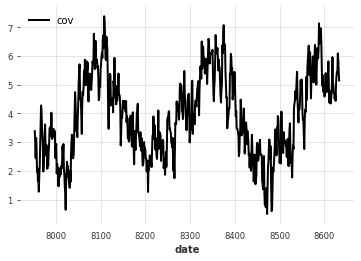

In [ ]:
predictions_secci = secci_model.predict(681, future_covariates=covariate_series_secci_scaled)
prediction_unscaled_secci = scaler_secci.inverse_transform(predictions_secci)
prediction_unscaled_secci.plot()

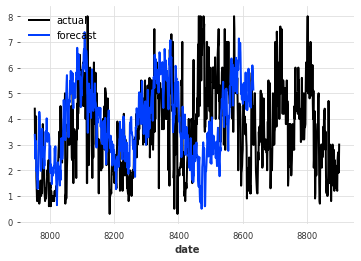

In [ ]:
val_secci.plot(label="actual")
prediction_unscaled_secci.plot(label="forecast")
plt.legend()

In [ ]:
rnn_secci_model = RNNModel(
    model="GRU",
    n_rnn_layers=1,
    hidden_dim=64,
    batch_size=64,
    n_epochs=20,
    random_state=0,
    training_length=941,
    input_chunk_length=260,
    model_name="secci_rnn",
    force_reset=True,
    save_checkpoints=True
)

rnn_secci_model.fit(
    series=secci_series,
    #val_series=val_secci_scaled,
    verbose=True,
    #val_future_covariates=val_cov_secci,
    future_covariates=covariate_series_secci_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 14.2 K
4 | V             | Linear           | 65    
---------------------------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
best_model_secci = RNNModel.load_from_checkpoint(model_name="secci_rnn", best=True)
predictions_secci_rnn = best_model_secci.predict(681, future_covariates=covariate_series_secci_scaled)
prediction_unscaled_secci_rnn = scaler_secci.inverse_transform(predictions_secci_rnn)
prediction_unscaled_secci_rnn.plot()

ERROR:darts.models.forecasting.torch_forecasting_model:FileNotFoundError: There is no file matching prefix best-* in /content/darts_logs/secci_rnn/checkpoints


FileNotFoundError: ignored

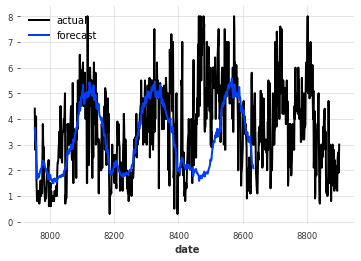

In [ ]:
val_secci.plot(label="actual")
prediction_unscaled_secci_rnn.plot(label="forecast")
plt.legend()

# Temperatur model

In [ ]:
train_temp, val_temp = temp_series.split_before(0.8)

scaler = Scaler(scaler_standard)
temp_series_scaled = scaler.fit_transform(temp_series)
#train_scaled = scaler.transform(train_temp)
#val_scaled = scaler.transform(val_temp)

#temp_model = DLinearModel(input_chunk_length=240, output_chunk_length=681, shared_weights=False, kernel_size=25, const_init=True, n_epochs=5)
#temp_model.fit(temp_series ,future_covariates=[covariate_series_temp_scaled]) #val_future_covariates=[val_cov_temp])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

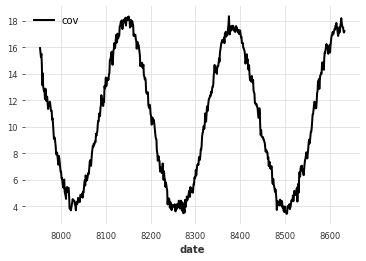

In [ ]:
predictions_temp = temp_model.predict(681, future_covariates=covariate_series_temp_scaled)
prediction_unscaled_temp = scaler.inverse_transform(predictions_temp)
prediction_unscaled_temp.plot()

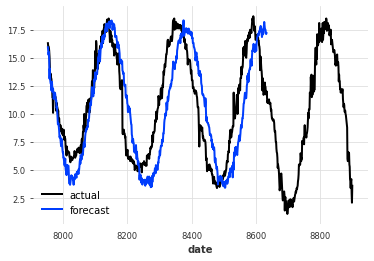

In [ ]:
val_temp.plot(label="actual")
prediction_unscaled_temp.plot(label="forecast")
plt.legend()

In [ ]:
rnn_temp_model = RNNModel(
    model="LSTM",
    n_rnn_layers=1,
    hidden_dim=64,
    batch_size=64,
    n_epochs=50,
    random_state=0,
    training_length=941,
    input_chunk_length=260,
    model_name="temp_rnn",
    force_reset=True,
    save_checkpoints=True
)

rnn_temp_model.fit(
    series=temp_series_scaled,
    #val_series=val_scaled,
    #val_future_covariates=val_cov_temp,
    future_covariates=covariate_series_temp_scaled,
    verbose=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 18.7 K
4 | V             | Linear           | 65    
---------------------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

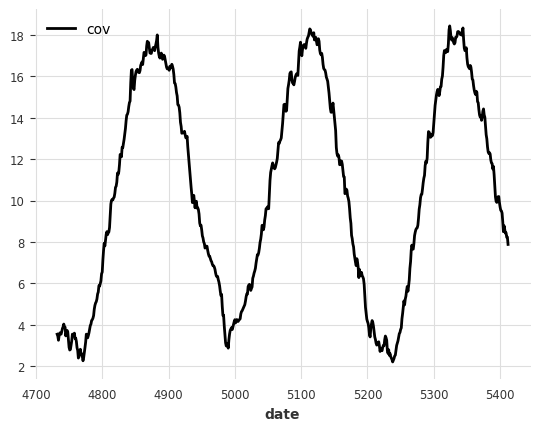

In [ ]:
#best_model_temp = RNNModel.load_from_checkpoint(model_name="temp_rnn", best=True)
predictions_temp_rnn = rnn_temp_model.predict(681, future_covariates=covariate_series_temp_scaled_11_13)
prediction_unscaled_temp_rnn = scaler.inverse_transform(predictions_temp_rnn)
prediction_unscaled_temp_rnn.plot()

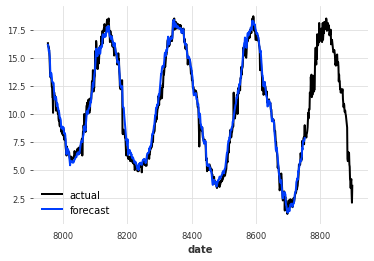

In [ ]:
val_temp.plot(label="actual")
prediction_unscaled_temp_rnn.plot(label="forecast")
plt.legend()

# Salinität model

In [ ]:
train_salin, val_salin = salin_series.split_before(0.8)

scaler_salin = Scaler(scaler_standard)
scaler_salin.fit(train_salin)
train_salin_scaled = scaler_salin.transform(train_salin)
val_salin_scaled = scaler_salin.transform(val_salin)

salin_model = DLinearModel(input_chunk_length=260, output_chunk_length=681, shared_weights=False, kernel_size=15, const_init=True, n_epochs=10)
salin_model.fit(train_salin_scaled,val_series=val_salin_scaled, future_covariates=[covariate_series_salin_scaled], val_future_covariates=[val_cov_salin])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 1.2 M 
5 | linear_trend    | Linear           | 1.2 M 
6 | linear_fut_cov  | Linear           | 7     
-----------------------------------------------------
2.5 M     Trainable params
0         Non-trainable pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

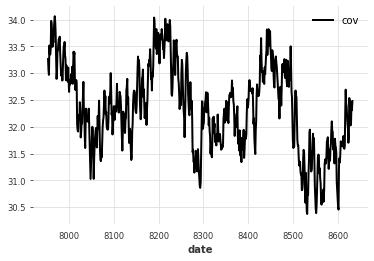

In [ ]:
predictions_salin = salin_model.predict(681, future_covariates=covariate_series_salin_scaled)
prediction_unscaled_salin = scaler_salin.inverse_transform(predictions_salin)
prediction_unscaled_salin.plot()

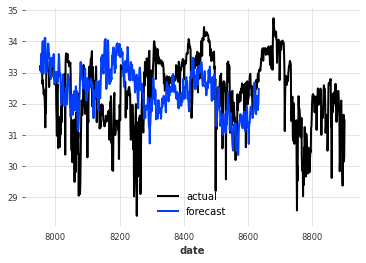

In [ ]:
val_salin.plot(label="actual")
prediction_unscaled_salin.plot(label="forecast")
plt.legend()

In [ ]:
rnn_salin_model = RNNModel(
    model="GRU",
    n_rnn_layers=2,
    hidden_dim=32,
    batch_size=64,
    n_epochs=50,
    random_state=0,
    training_length=941,
    input_chunk_length=260,
    model_name="salin_rnn",
    force_reset=True,
    save_checkpoints=True
)

rnn_salin_model.fit(
    series=salin_series,
    #val_series=val_salin_scaled,
    verbose=True,
    #val_future_covariates=val_cov_salin,
    future_covariates=covariate_series_salin_scaled,)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 10.3 K
4 | V             | Linear           | 33    
---------------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
#best_model_salin = RNNModel.load_from_checkpoint(model_name="salin_rnn", best=True)
predictions_salin_rnn = rnn_salin_model.predict(681, future_covariates=covariate_series_salin_scaled)
prediction_unscaled_salin_rnn = scaler_salin.inverse_transform(predictions_salin_rnn)
prediction_unscaled_salin_rnn.plot()

ERROR:main_logger:ValueError: For the given forecasting horizon `n=681`, the provided future covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the future covariates must end at time step `5412`, whereas now they end at time step `4731`.


ValueError: ignored

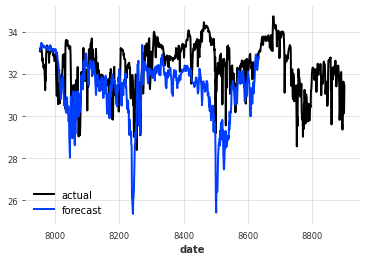

In [ ]:
val_salin.plot(label="actual")
prediction_unscaled_salin_rnn.plot(label="forecast")
plt.legend()

In [ ]:
combined_forecast_salin = 0.6 * prediction_unscaled_salin_rnn + 0.4 * prediction_unscaled_salin

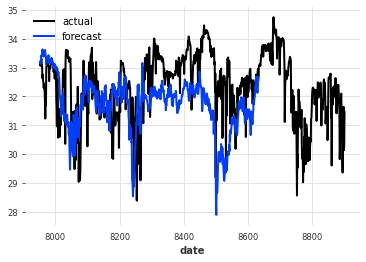

In [ ]:
val_salin.plot(label="actual")
combined_forecast_salin.plot(label="forecast")
plt.legend()

# NO2 model

In [ ]:
train_no2, val_no2 = no2_series.split_before(0.8)

scaler_no2 = Scaler(scaler_standard)
no2_series_scaled = scaler_no2.fit_transform(no2_series)
#train_no2_scaled = scaler_no2.transform(train_no2)
#val_no2_scaled = scaler_no2.transform(val_no2)

#no2_model = DLinearModel(input_chunk_length=260, output_chunk_length=681, shared_weights=False, kernel_size=25, const_init=True, n_epochs=10)
#no2_model.fit(train_no2_scaled,val_series=val_no2_scaled, future_covariates=[covariate_series_no2_scaled], val_future_covariates=[val_cov_no2])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

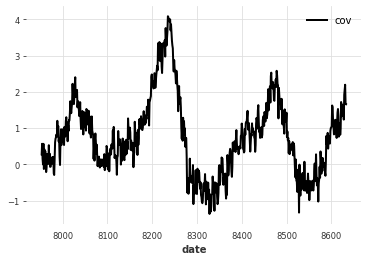

In [ ]:
predictions_no2 = no2_model.predict(681, future_covariates=covariate_series_no2_scaled)
prediction_unscaled_no2 = scaler_no2.inverse_transform(predictions_no2)
prediction_unscaled_no2.plot()

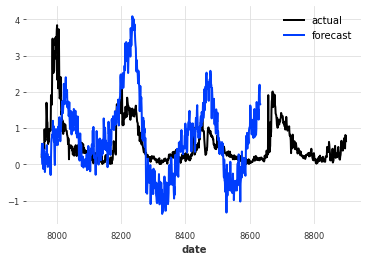

In [ ]:
val_no2.plot(label="actual")
prediction_unscaled_no2.plot(label="forecast")
plt.legend()

In [ ]:
rnn_no2_model = RNNModel(
    model="LSTM",
    n_rnn_layers=3,
    hidden_dim=64,
    batch_size=64,
    n_epochs=20,
    random_state=0,
    training_length=941,
    input_chunk_length=260,
    model_name="no2_rnn",
    force_reset=True,
    save_checkpoints=True
)

rnn_no2_model.fit(
    series=no2_series_scaled,
    #val_series=val_no2_scaled,
    verbose=True,
    #val_future_covariates=val_cov_no2,
    future_covariates=covariate_series_no2_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 85.2 K
4 | V             | Linear           | 65    
---------------------------------------------------
85.3 K    Trainable params
0         Non-trainable params
85.3 K    Total params
0.341     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

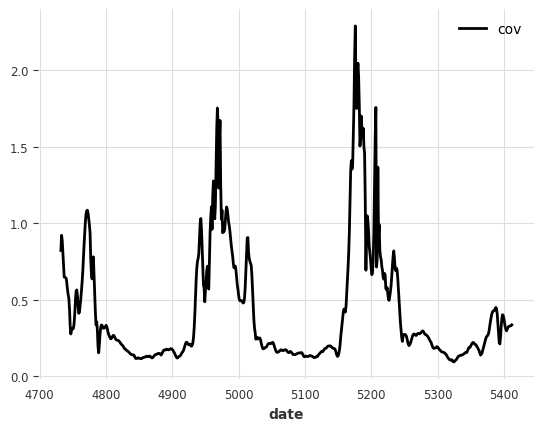

In [ ]:
#best_model_no2 = RNNModel.load_from_checkpoint(model_name="no2_rnn", best=True)
predictions_no2_rnn = rnn_no2_model.predict(681, future_covariates=covariate_series_no2_scaled_11_13)
prediction_unscaled_no2_rnn = scaler_no2.inverse_transform(predictions_no2_rnn)
prediction_unscaled_no2_rnn.plot()

In [ ]:
no2_predictions_04 = rnn_no2_model.predict(series=no2_series_04_scaled, n=233, future_covariates=covariate_series_no2_scaled_04)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
no2_predictions_04_unscaled = scaler_no2.inverse_transform(no2_predictions_04)
no2_predictions_04_unscaled_df = no2_predictions_04_unscaled.pd_dataframe()
no2_predictions_11_13_unscaled_df = prediction_unscaled_no2_rnn.pd_dataframe()
no2_predictions_04_unscaled_df['NO2'] = no2_predictions_04_unscaled_df['cov']
no2_predictions_11_13_unscaled_df['NO2'] = no2_predictions_11_13_unscaled_df['cov']

In [ ]:
final_no2 = pd.DataFrame(pd.concat([no2_predictions_04_unscaled_df['NO2'], no2_predictions_11_13_unscaled_df['NO2']],ignore_index=True),columns=['NO2'])

In [ ]:
data_no2 = { 'NO2': [0]}
substitute_no2 = pd.DataFrame(data=data_no2)
very_final_no2 = pd.DataFrame(pd.concat([substitute_no2['NO2'], final_no2['NO2']],ignore_index=True),columns=['NO2'])

In [ ]:
final_frame['NO2'] = 0.5 * final_frame['NO2'] + 0.5 * very_final_no2['NO2']

In [ ]:
very_final_no2['NO2'].mean()

0.4694715977610786

# NO3 model

In [ ]:
train_no3, val_no3 = no3_series.split_before(0.8)

scaler_no3 = Scaler(scaler_standard)
no3_series_scaled = scaler_no3.fit_transform(no3_series)
#train_no3_scaled = scaler_no3.transform(train_no3)
#val_no3_scaled = scaler_no3.transform(val_no3)


#no3_model = DLinearModel(input_chunk_length=260, output_chunk_length=681, shared_weights=False, kernel_size=25, const_init=True, n_epochs=10)
#no3_model.fit(train_no3_scaled, future_covariates=[covariate_series_no3_scaled], val_series=val_no3_scaled, val_future_covariates=[val_cov_no3])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

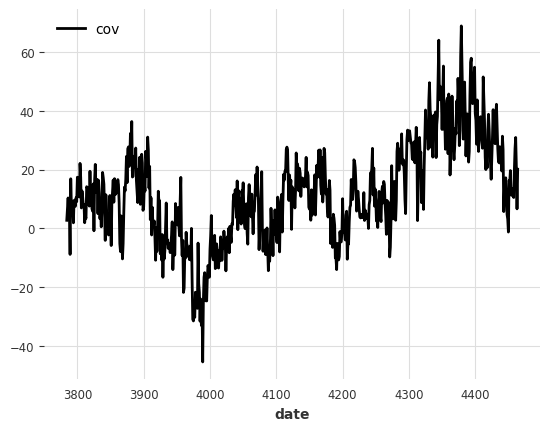

In [ ]:
predictions_no3 = no3_model.predict(681, future_covariates=covariate_series_no3_scaled)
prediction_unscaled_no3 = scaler_no3.inverse_transform(predictions_no3)
prediction_unscaled_no3.plot()

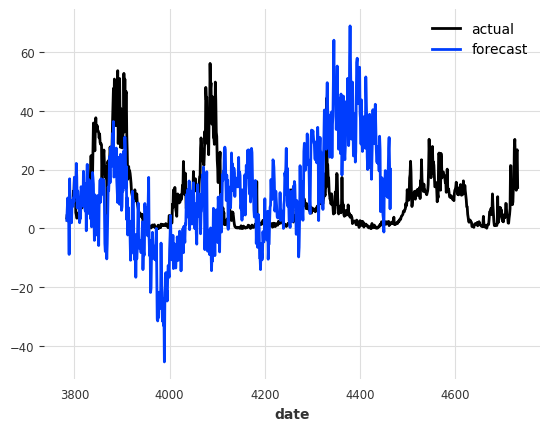

In [ ]:
val_no3.plot(label="actual")
prediction_unscaled_no3.plot(label="forecast")
plt.legend()

In [ ]:
rnn_no3_model = RNNModel(
    model="LSTM",
    n_rnn_layers=8,
    hidden_dim=32,
    batch_size=64,
    n_epochs=40,
    random_state=0,
    training_length=941,
    input_chunk_length=260,
    model_name="no3_rnn",
    force_reset=True,
    save_checkpoints=True
)

rnn_no3_model.fit(
    series=no3_series_scaled,
    #val_series=val_no3_scaled,
    verbose=True,
    #val_future_covariates=val_cov_no3,
    future_covariates=covariate_series_no3_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 64.5 K
4 | V             | Linear           | 33    
---------------------------------------------------
64.5 K    Trainable params
0         Non-trainable params
64.5 K    Total params
0.258     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

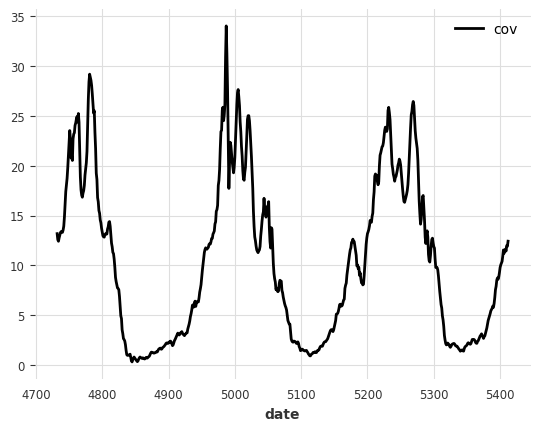

In [ ]:
#best_model_no3 = RNNModel.load_from_checkpoint(model_name="no3_rnn", best=True)
predictions_no3_rnn = rnn_no3_model.predict(681, future_covariates=covariate_series_no3_scaled_11_13)
prediction_unscaled_no3_rnn = scaler_no3.inverse_transform(predictions_no3_rnn)
prediction_unscaled_no3_rnn.plot()

In [ ]:
no3_predictions_04 = rnn_no3_model.predict(series=no3_series_04_scaled, n=233, future_covariates=covariate_series_no3_scaled_04)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
no3_predictions_04_unscaled = scaler_no3.inverse_transform(no3_predictions_04)
no3_predictions_04_unscaled_df = no3_predictions_04_unscaled.pd_dataframe()
no3_predictions_11_13_unscaled_df = prediction_unscaled_no3_rnn.pd_dataframe()
no3_predictions_04_unscaled_df['NO3'] = no3_predictions_04_unscaled_df['cov']
no3_predictions_11_13_unscaled_df['NO3'] = no3_predictions_11_13_unscaled_df['cov']

In [ ]:
final_no3 = pd.DataFrame(pd.concat([no3_predictions_04_unscaled_df['NO3'], no3_predictions_11_13_unscaled_df['NO3']],ignore_index=True),columns=['NO3'])

In [ ]:
data_no3 = { 'NO3': [0]}
substitute_no3 = pd.DataFrame(data=data_no3)
very_final_no3 = pd.DataFrame(pd.concat([substitute_no3['NO3'], final_no3['NO3']],ignore_index=True),columns=['NO3'])

In [ ]:
very_final_no3

,NO3
0,0.000000
1,7.622925
2,7.710877
3,7.805727
4,7.612214
...,...
910,9.893383
911,9.837242
912,10.253531
913,10.301810


In [ ]:
final_frame['NO3'] = 0.3 * final_frame['NO3'] + 0.7 * very_final_no3['NO3']

In [ ]:
final_frame['NOx'] = final_frame['NO3'] + final_frame['NO2'] 

In [ ]:
final_frame['NOx'].var()

70.69178058118372

# Predicting values with darts models

In [ ]:
#secci_series_scaled = scaler_secci.transform(secci_series)
#temp_series_scaled = scaler.transform(temp_series)
#salin_series_scaled = scaler_salin.transform(salin_series)
no2_series_scaled = scaler_no2.transform(no2_series)
no3_series_scaled = scaler_no3.transform(no3_series)

#secci_series_04_scaled = scaler_secci.transform(secci_series_04)
#temp_series_04_scaled = scaler.transform(temp_series_04)
#salin_series_04_scaled = scaler_salin.transform(salin_series_04)
no2_series_04_scaled = scaler_no2.transform(no2_series_04)
no3_series_04_scaled = scaler_no3.transform(no3_series_04)

**SECCHI prediction**

In [ ]:
secci_predictions_04 = rnn_model_secci.predict(series=secci_series_04_scaled, n=233, future_covariates=covariate_series_secci_scaled_04)
secci_predictions_11_13 = best_model_secci.predict(series=secci_series_scaled, n=681, future_covariates=covariate_series_secci_scaled_11_13)

NameError: ignored

**Temperature prediction**

In [ ]:
temp_predictions_04 = best_model_temp.predict(series=temp_series_04_scaled, n=233, future_covariates=covariate_series_temp_scaled_04)
temp_predictions_11_13 = best_model_temp.predict(series=temp_series_scaled, n=681, future_covariates=covariate_series_temp_scaled_11_13)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

**Salinität prediction**

In [ ]:
salin_predictions_04 = best_model_salin.predict(series=salin_series_04_scaled, n=233, future_covariates=covariate_series_salin_scaled_04)
salin_predictions_11_13 = best_model_salin.predict(series=salin_series_scaled, n=681, future_covariates=covariate_series_salin_scaled_11_13)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

**NO2 prediction**

In [ ]:
#no2_predictions_04 = no2_model.predict(series=no2_series_04_scaled, n=233, future_covariates=covariate_series_no2_scaled_04)
#no2_predictions_11_13 = no2_model.predict(series=no2_series_scaled, n=681, future_covariates=covariate_series_no2_scaled_11_13)

#no2_dlinear_04 = no2_model.predict(series=no2_series_04_scaled, n=233, future_covariates=covariate_series_no2_scaled_04)
no2_predictions_04 = best_model_no2.predict(series=no2_series_04_scaled, n=233, future_covariates=covariate_series_no2_scaled_04)

#no2_predictions_04 = 0.7 * no2_dlinear_04 + 0.3 * no2_rnn_04

#no2_dlinear_11_13 = no2_model.predict(series=no2_series_scaled, n=681, future_covariates=covariate_series_no2_scaled_11_13)
no2_predictions_11_13 = best_model_no2.predict(series=no2_series_scaled, n=681, future_covariates=covariate_series_no2_scaled_11_13)

#no2_predictions_11_13 = 0.7 * no2_dlinear_11_13 + 0.3 * no2_rnn_11_13

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

**NO3 prediction**

In [ ]:
#no3_dlinear_04 = no3_model.predict(series=no3_series_04_scaled, n=233, future_covariates=covariate_series_no3_scaled_04)
no3_predictions_04 = best_model_no3.predict(series=no3_series_04_scaled, n=233, future_covariates=covariate_series_no3_scaled_04)

#no3_predictions_04 = 0 * no3_dlinear_04 + 1 * no3_rnn_04

#no3_dlinear_11_13 = no3_model.predict(series=no3_series_scaled, n=681, future_covariates=covariate_series_no3_scaled_11_13)
no3_predictions_11_13 = best_model_no3.predict(series=no3_series_scaled, n=681, future_covariates=covariate_series_no3_scaled_11_13)

#no3_predictions_11_13 = 0 * no3_dlinear_11_13 + 1 * no3_rnn_11_13

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

**NOX prediction**

**Final frame**

In [ ]:
secci_predictions_04_unscaled = scaler_secci.inverse_transform(secci_predictions_04)
secci_predictions_11_13_unscaled = scaler_secci.inverse_transform(secci_predictions_11_13)
secci_predictions_04_unscaled_df = secci_predictions_04_unscaled.pd_dataframe()
secci_predictions_11_13_unscaled_df = secci_predictions_11_13_unscaled.pd_dataframe()
secci_predictions_04_unscaled_df['SECCI'] = secci_predictions_04_unscaled_df['cov']
secci_predictions_11_13_unscaled_df['SECCI'] = secci_predictions_11_13_unscaled_df['cov']

temp_predictions_04_unscaled = scaler.inverse_transform(temp_predictions_04)
temp_predictions_11_13_unscaled = scaler.inverse_transform(temp_predictions_11_13)
temp_predictions_04_unscaled_df = temp_predictions_04_unscaled.pd_dataframe()
temp_predictions_11_13_unscaled_df = temp_predictions_11_13_unscaled.pd_dataframe()
temp_predictions_04_unscaled_df['Temperatur'] = temp_predictions_04_unscaled_df['cov']
temp_predictions_11_13_unscaled_df['Temperatur'] = temp_predictions_11_13_unscaled_df['cov']

salin_predictions_04_unscaled = scaler_salin.inverse_transform(salin_predictions_04)
salin_predictions_11_13_unscaled = scaler_salin.inverse_transform(salin_predictions_11_13)
salin_predictions_04_unscaled_df = salin_predictions_04_unscaled.pd_dataframe()
salin_predictions_11_13_unscaled_df = salin_predictions_11_13_unscaled.pd_dataframe()
salin_predictions_04_unscaled_df['Salinität'] = salin_predictions_04_unscaled_df['cov']
salin_predictions_11_13_unscaled_df['Salinität'] = salin_predictions_11_13_unscaled_df['cov']

no2_predictions_04_unscaled = scaler_no2.inverse_transform(no2_predictions_04)
no2_predictions_11_13_unscaled = scaler_no2.inverse_transform(no2_predictions_11_13)
no2_predictions_04_unscaled_df = no2_predictions_04_unscaled.pd_dataframe()
no2_predictions_11_13_unscaled_df = no2_predictions_11_13_unscaled.pd_dataframe()
no2_predictions_04_unscaled_df['NO2'] = no2_predictions_04_unscaled_df['cov']
no2_predictions_11_13_unscaled_df['NO2'] = no2_predictions_11_13_unscaled_df['cov']

no3_predictions_04_unscaled = scaler_no3.inverse_transform(no3_predictions_04)
no3_predictions_11_13_unscaled = scaler_no3.inverse_transform(no3_predictions_11_13)
no3_predictions_04_unscaled_df = no3_predictions_04_unscaled.pd_dataframe()
no3_predictions_11_13_unscaled_df = no3_predictions_11_13_unscaled.pd_dataframe()
no3_predictions_04_unscaled_df['NO3'] = no3_predictions_04_unscaled_df['cov'] #map(lambda x: x*0.2 if x<25 else x)
no3_predictions_11_13_unscaled_df['NO3'] = no3_predictions_11_13_unscaled_df['cov'].map(lambda x: x*0.11 if x<29 else x)

nox_predictions_04 = no2_predictions_04_unscaled_df['NO2'] + no3_predictions_04_unscaled_df['NO3']
nox_predictions_11_13 = no2_predictions_11_13_unscaled_df['NO2'] + no3_predictions_11_13_unscaled_df['NO3']
nox_predictions_04_df = pd.DataFrame(nox_predictions_04,columns=['NOx'])
nox_predictions_11_13_df = pd.DataFrame(nox_predictions_11_13,columns=['NOx'])

In [ ]:
data = {'SECCI': [0], 'Temperatur': [0],'Salinität': [0], 'NO2': [0], 'NO3': [0], 'NOx': [0]}
substitute = pd.DataFrame(data=data)

In [ ]:
final_sechi = pd.DataFrame(pd.concat([secci_predictions_04_unscaled_df['SECCI'], secci_predictions_11_13_unscaled_df['SECCI']],ignore_index=True),columns=['SECCI'])
final_temp = pd.DataFrame(pd.concat([temp_predictions_04_unscaled_df['Temperatur'], temp_predictions_11_13_unscaled_df['Temperatur']],ignore_index=True),columns=['Temperatur'])
final_salin = pd.DataFrame(pd.concat([salin_predictions_04_unscaled_df['Salinität'], salin_predictions_11_13_unscaled_df['Salinität']],ignore_index=True),columns=['Salinität'])
final_no2 = pd.DataFrame(pd.concat([no2_predictions_04_unscaled_df['NO2'], no2_predictions_11_13_unscaled_df['NO2'] ],ignore_index=True),columns=['NO2'])
final_no3 = pd.DataFrame(pd.concat([no3_predictions_04_unscaled_df['NO3'], no3_predictions_11_13_unscaled_df['NO3']],ignore_index=True),columns=['NO3'])
final_nox = pd.DataFrame(pd.concat([nox_predictions_04_df['NOx'], nox_predictions_11_13_df['NOx']],ignore_index=True),columns=['NOx'])
prefinal_frame = pd.concat([final_sechi, final_temp, final_salin, final_no2, final_no3, final_nox], axis=1).round(3)
final_frame = pd.concat([substitute, prefinal_frame],ignore_index=True, axis=0)

In [ ]:
secci_predictions_04_unscaled.reset_index(inplace=True)

In [ ]:
secci_values_04 = secci_predictions_04_unscaled_df['cov']
secci_values_11_13 = secci_predictions_11_13_unscaled_df['cov']
final_sechi = pd.DataFrame(pd.concat([secci_values_04, secci_values_11_13],ignore_index=True))

In [ ]:
nox_predictions_11_13

date
4732    0.867632
4733    0.900549
4734    0.931104
4735    0.958388
4736    0.950473
          ...   
5408    1.263686
5409    1.263156
5410    1.280807
5411    1.284244
5412    1.279403
Length: 681, dtype: float64

<Axes: >

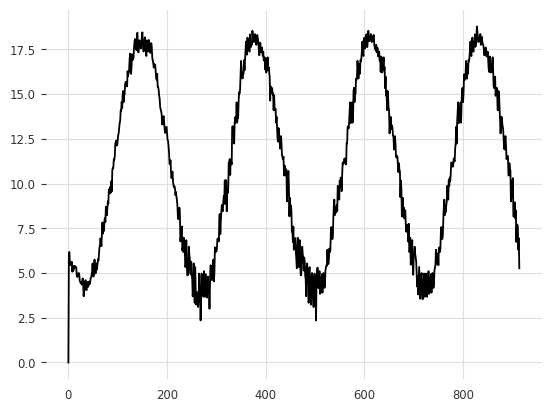

In [ ]:
final_frame['Temperatur'].plot()

In [ ]:
final_predictions.update(final_frame, overwrite=False)
final_predictions.to_csv('bbdc_2023_AWI_data_evaluate_skeleton_student.csv', index=False, sep=';')

In [ ]:
from google.colab import files
files.download('bbdc_2023_AWI_data_evaluate_skeleton_student.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Means: [ 3.67538293 10.4809628  32.21740044  0.55346827  9.53884026 10.09414661]
Variance: [ 3.25649466 24.84346691  1.11161782  0.51352747 76.51075248 79.02745556]

# Exploring autocorrelation and trend

**Exploring the autocorrelation**

In [ ]:
def get_yearly_autocorr(data):
    ac = acf(data, nlags=366)
    return (0.5 * ac[365]) + (0.25 * ac[364]) + (0.25 * ac[366])

sub_sechi_data = darts_data['SECCI']
sub_temp_data = darts_data['Temperatur']
sub_salin_data = darts_data['Salinität']
sub_no2_data = darts_data['NO2']
sub_no3_data = darts_data['NO3']

secchi_autocorr = get_yearly_autocorr(sub_sechi_data)
temp_autocorr = get_yearly_autocorr(sub_temp_data)
salin_autocorr = get_yearly_autocorr(sub_salin_data)
no2_autocorr = get_yearly_autocorr(sub_no2_data)
no3_autocorr = get_yearly_autocorr(sub_no3_data)


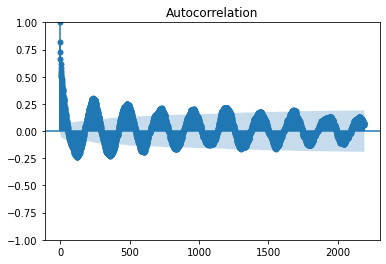

In [ ]:
plot_acf(sub_sechi_data, lags=6*365)
plt.show()

In [ ]:
secchi_autocorr

-0.21140537316002572

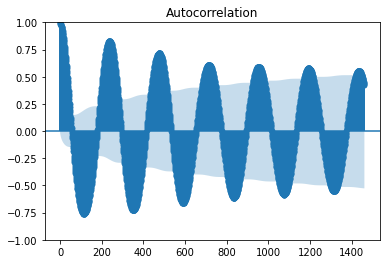

In [ ]:
plot_acf(sub_temp_data, lags=4*365)
plt.show()

In [ ]:
temp_autocorr

-0.6888855538110198

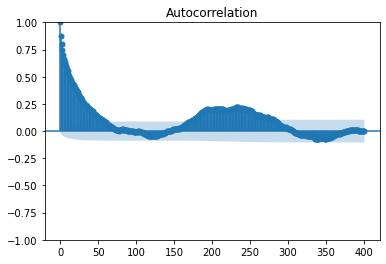

In [ ]:
plot_acf(sub_salin_data, lags=400)
plt.show()

In [ ]:
salin_autocorr

-0.025016250272551548

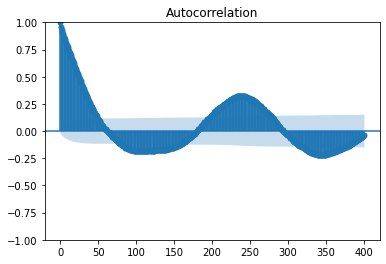

In [ ]:
plot_acf(sub_no2_data, lags=400)
plt.show()

In [ ]:
no2_autocorr

-0.17985339241132503

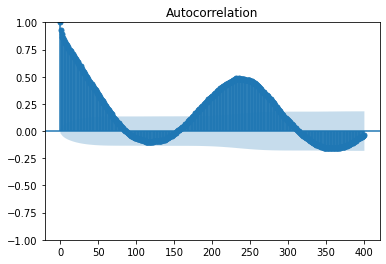

In [ ]:
plot_acf(sub_no3_data, lags=400)
plt.show()

In [ ]:
no3_autocorr

-0.15626594816740746

**Explore the trend**

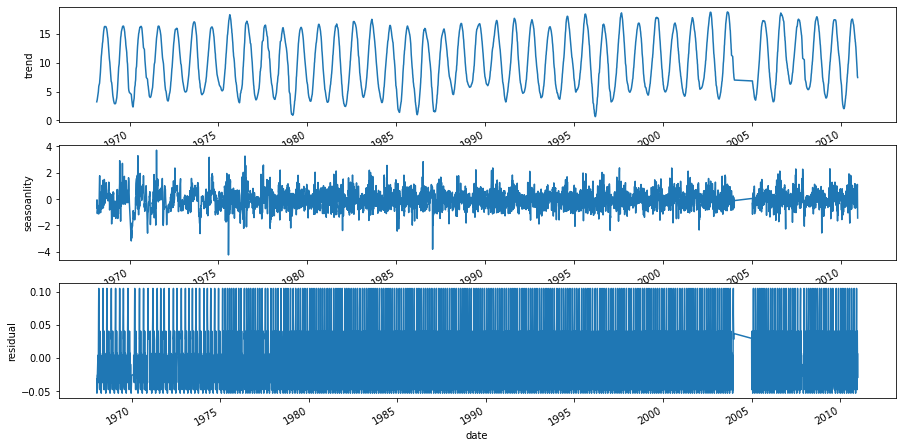

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(sub_temp_data, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

# Function for splitting the data into train and validation data

In [ ]:
# Source: Approach 4 from this blog post https://mobiarch.wordpress.com/2020/11/13/preparing-time-series-data-for-rnn-in-tensorflow/

def timeseries_dataset_multistep_combined(dataset, target_slice, input_slice, predict_date_to_data, input_sequence_length, output_sequence_length, sampling_rate=1, batch_size=32, shuffle=False, start_index=0, end_index=None):
    if end_index == None:
        end_index = len(dataset) -1

    time_series_dataset = tf.keras.utils.timeseries_dataset_from_array(
        dataset,
        targets = None,
        sampling_rate = sampling_rate,
        sequence_length = input_sequence_length ,  # + output_sequence_length
        shuffle = shuffle,
        batch_size = batch_size,
        start_index = start_index,
        end_index = end_index)
    
    def split_feature_label(x):
        return x[:, :input_sequence_length, :], x[:, input_sequence_length:, target_slice]

    def split_feature_label_pred_year(x):
        return x[:, :input_sequence_length, input_slice:], x[:, :input_sequence_length, target_slice]

    if predict_date_to_data:
      time_series_dataset = time_series_dataset.map(split_feature_label_pred_year)
    else:
      time_series_dataset = time_series_dataset.map(split_feature_label)
     
    return time_series_dataset

In [ ]:
sampling_rate = 1
sequence_length = 681
output_sequence_length = 681
delay = sampling_rate * (sequence_length + output_sequence_length - 1)
batch_size = 64

def get_datasets(data, input_slice, predict_date_to_data, slice_start, slice_end, start_idx_train, end_idx_train, strat_idx_valid, end_idx_valid):
  train_dataset = timeseries_dataset_multistep_combined(
      data.to_numpy(),
      target_slice = slice(slice_start,slice_end,None),
      sampling_rate = sampling_rate,
      input_sequence_length=sequence_length,
      output_sequence_length = output_sequence_length,
      shuffle = True,
      batch_size = batch_size,
      start_index = start_idx_train,
      end_index = end_idx_train,
      input_slice=input_slice, 
      predict_date_to_data=predict_date_to_data)

  val_dataset = timeseries_dataset_multistep_combined(
      data.to_numpy(),
      target_slice = slice(slice_start,slice_end,None),
      sampling_rate = sampling_rate,
      input_sequence_length=sequence_length,
      output_sequence_length = output_sequence_length,
      shuffle = True,
      batch_size = batch_size,
      start_index = strat_idx_valid,
      end_index = end_idx_valid,
      input_slice=input_slice, 
      predict_date_to_data=predict_date_to_data)
  
  return train_dataset, val_dataset

# Classic train/validation split

In [ ]:
n = len(darts_data)
train_df = darts_data.loc[:'1999-12-30']
val_df = darts_data.loc['2000-01-01':]

num_train_samples = len(train_df)
num_val_samples = len(val_df)

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()


train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
darts_data_df_normalised = (darts_data - train_mean) / train_std

In [ ]:
darts_data_df_normalised

,SECCI,Temperatur,Salinität,NO2,NO3,Day sin,Day cos,Year sin,Year cos,year_mod
date,,,,,,,,,,
1968-01-08 10:10:00,-1.227409,-1.232105,0.980436,-0.951134,-0.384647,-1.883767,-1.597644,0.180874,1.445087,-1.984953
1968-01-12 09:40:00,-1.393425,-1.650698,-1.469230,-0.830588,0.221080,-1.296080,-1.335581,0.276128,1.430258,-1.984953
1968-01-15 09:40:00,-1.116732,-1.590899,-0.249979,-0.977922,0.238914,-1.296080,-1.335581,0.347155,1.414750,-1.984953
1968-01-22 09:20:00,-1.006055,-1.311837,0.041078,-0.910952,0.098090,-0.932355,-1.130484,0.508796,1.364476,-1.984953
1968-02-02 10:05:00,-1.338086,-1.371637,-0.647093,-0.857376,-0.806503,-1.782655,-1.557928,0.748612,1.246398,-1.984953
...,...,...,...,...,...,...,...,...,...,...
2010-12-21 09:25:00,-0.452670,-1.212172,-0.944529,-0.495737,0.075952,-1.020981,-1.183933,-0.240291,1.431771,2.900804
2010-12-22 08:15:00,-0.397331,-1.172306,-0.320950,-0.602889,-0.285025,0.059224,-0.317655,-0.217588,1.435782,2.900804
2010-12-28 08:30:00,-0.840039,-1.431435,-1.521859,-0.107310,0.521792,-0.141088,-0.523074,-0.072979,1.452404,2.900804


In [ ]:
# Classic validation scheme
sechi_train_dataset, sechi_val_dataset = get_datasets(darts_data_df_normalised,None,False,0,1,0,num_train_samples,num_train_samples,num_train_samples+num_val_samples-1)
temp_train_dataset, temp_val_dataset = get_datasets(darts_data_df_normalised,None,False,1,2,0,num_train_samples,num_train_samples,num_train_samples+num_val_samples-1)
salin_train_dataset, salin_val_dataset = get_datasets(darts_data_df_normalised,None,False,2,3,0,num_train_samples,num_train_samples,num_train_samples+num_val_samples-1)
no2_train_dataset, no2_val_dataset = get_datasets(darts_data_df_normalised,None,False,3,4,0,num_train_samples,num_train_samples,num_train_samples+num_val_samples-1)
no3_train_dataset, no3_val_dataset = get_datasets(darts_data_df_normalised,None,False,4,5,0,num_train_samples,num_train_samples,num_train_samples+num_val_samples-1)


# The walk forward split

In [ ]:
def normalise_data(data):  
  mean = data.mean()
  std = data.std()

  data_normalised = (data - mean) / std
  return data_normalised

In [ ]:
walk_forward_normalised_standard = normalise_data(darts_data)
walk_forward_helgo = normalise_data(darts_data_helgo)
#walk_forward_phyto = normalise_data(darts_data_phyto)
#walk_forward_helgo_phyto = normalise_data(darts_data_helgo_phyto)

**Creating reduced datasets for each parameter**

In [ ]:
# set for data without any additional data
sechi_reduced = walk_forward_normalised_standard.drop(walk_forward_normalised_standard.columns[[1,2,3,4]], axis=1)
temp_reduced = walk_forward_normalised_standard.drop(walk_forward_normalised_standard.columns[[0,2]], axis=1)
salin_reduced = walk_forward_normalised_standard.drop(walk_forward_normalised_standard.columns[[0,1,3,4]], axis=1)
no2_reduced = walk_forward_normalised_standard.drop(walk_forward_normalised_standard.columns[[0,2]], axis=1)
no3_reduced = walk_forward_normalised_standard.drop(walk_forward_normalised_standard.columns[[0,2]], axis=1)

In [ ]:
# set for data with additional helgoland data
sechi_reduced_helgo = walk_forward_helgo.drop(walk_forward_helgo.columns[[1,2,3,4]], axis=1)
temp_reduced_helgo = walk_forward_helgo.drop(walk_forward_helgo.columns[[0,2]], axis=1)
salin_reduced_helgo = walk_forward_helgo.drop(walk_forward_helgo.columns[[0,1,3,4]], axis=1)
no2_reduced_helgo = walk_forward_helgo.drop(walk_forward_helgo.columns[[0,2]], axis=1)
no3_reduced_helgo = walk_forward_helgo.drop(walk_forward_helgo.columns[[0,2]], axis=1)

In [ ]:
# set for data with additional phyto data
sechi_reduced_phyto = walk_forward_phyto.drop(walk_forward_phyto.columns[[1,2,3,4]], axis=1)
temp_reduced_phyto = walk_forward_phyto.drop(walk_forward_phyto.columns[[0,2]], axis=1)
salin_reduced_phyto = walk_forward_phyto.drop(walk_forward_phyto.columns[[0,1,3,4]], axis=1)
no2_reduced_phyto = walk_forward_phyto.drop(walk_forward_phyto.columns[[0,2]], axis=1)
no3_reduced_phyto = walk_forward_phyto.drop(walk_forward_phyto.columns[[0,2]], axis=1)

In [ ]:
# set for data with additional helgoland as well as phyto data
sechi_reduced_helgo_phyto = walk_forward_helgo_phyto.drop(walk_forward_helgo_phyto.columns[[1,2,3,4]], axis=1)
temp_reduced_helgo_phyto = walk_forward_helgo_phyto.drop(walk_forward_helgo_phyto.columns[[0,2]], axis=1)
salin_reduced_helgo_phyto = walk_forward_helgo_phyto.drop(walk_forward_helgo_phyto.columns[[0,1,3,4]], axis=1)
no2_reduced_helgo_phyto = walk_forward_helgo_phyto.drop(walk_forward_helgo_phyto.columns[[0,2]], axis=1)
no3_reduced_helgo_phyto = walk_forward_helgo_phyto.drop(walk_forward_helgo_phyto.columns[[0,2]], axis=1)

**Walk forward split with the data without any additional data**

In [ ]:
# Walk forward scheme
sechi_train_dataset_wf, sechi_val_dataset_wf = get_datasets(sechi_reduced,1,True,0,1,0,len(walk_forward_normalised_standard)-1,output_sequence_length,len(walk_forward_normalised_standard)-1)
temp_train_dataset_wf, temp_val_dataset_wf = get_datasets(temp_reduced,3,True,0,1,0,len(walk_forward_normalised_standard)-1,output_sequence_length,len(walk_forward_normalised_standard)-1)
salin_train_dataset_wf, salin_val_dataset_wf = get_datasets(salin_reduced,1,True,0,1,0,len(walk_forward_normalised_standard)-1,output_sequence_length,len(walk_forward_normalised_standard)-1)
no2_train_dataset_wf, no2_val_dataset_wf = get_datasets(no2_reduced,3,True,1,2,0,len(walk_forward_normalised_standard)-1,output_sequence_length,len(walk_forward_normalised_standard)-1)
no3_train_dataset_wf, no3_val_dataset_wf = get_datasets(no3_reduced,3,True,2,3,0,len(walk_forward_normalised_standard)-1,output_sequence_length,len(walk_forward_normalised_standard)-1)

**Walk forward split for data with Helgoland weather data added**

In [ ]:
# Walk froward scheme but with Hegloland data added
sechi_train_dataset_wf_helgo, sechi_val_dataset_wf_helgo = get_datasets(sechi_reduced_helgo,1,True,0,1,0,len(walk_forward_helgo)-1,output_sequence_length,len(sechi_reduced_helgo)-1)
temp_train_dataset_wf_helgo, temp_val_dataset_wf_helgo = get_datasets(temp_reduced_helgo,3,True,0,1,0,len(walk_forward_helgo)-1,output_sequence_length,len(sechi_reduced_helgo)-1)
salin_train_dataset_wf_helgo, salin_val_dataset_wf_helgo = get_datasets(salin_reduced_helgo,1,True,0,1,0,len(walk_forward_helgo)-1,output_sequence_length,len(sechi_reduced_helgo)-1)
no2_train_dataset_wf_helgo, no2_val_dataset_wf_helgo = get_datasets(no2_reduced_helgo,3,True,1,2,0,len(walk_forward_helgo)-1,output_sequence_length,len(sechi_reduced_helgo)-1)
no3_train_dataset_wf_helgo, no3_val_dataset_wf_helgo = get_datasets(no3_reduced_helgo,3,True,2,3,0,len(walk_forward_helgo)-1,output_sequence_length,len(sechi_reduced_helgo)-1)

**Walk forward split for data with phytoplankton data added**

In [ ]:
# Walk forward scheme but with phytoplankton data added
sechi_train_dataset_wf_phyto, sechi_val_dataset_wf_phyto = get_datasets(sechi_reduced_phyto,1,True,0,1,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)
temp_train_dataset_wf_phyto, temp_val_dataset_wf_phyto = get_datasets(temp_reduced_phyto,3,True,0,1,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)
salin_train_dataset_wf_phyto, salin_val_dataset_wf_phyto = get_datasets(salin_reduced_phyto,1,True,0,1,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)
no2_train_dataset_wf_phyto, no2_val_dataset_wf_phyto = get_datasets(no2_reduced_phyto,3,True,1,2,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)
no3_train_dataset_wf_phyto, no3_val_dataset_wf_phyto = get_datasets(no3_reduced_phyto,3,True,2,3,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)

**Walk forward for data with Helgoland as well as phytoplankton data added**

In [ ]:
# Walk forward scheme with Helgoland as well as Phytoplankton data
sechi_train_dataset_wf_helgo_phyto, sechi_val_dataset_wf_helgo_phyto = get_datasets(sechi_reduced_helgo_phyto,1,True,0,1,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)
temp_train_dataset_wf_helgo_phyto, temp_val_dataset_wf_helgo_phyto = get_datasets(temp_reduced_helgo_phyto,3,True,0,1,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)
salin_train_dataset_wf_helgo_phyto, salin_val_dataset_wf_helgo_phyto = get_datasets(salin_reduced_helgo_phyto,1,True,0,1,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)
no2_train_dataset_wf_helgo_phyto, no2_val_dataset_wf_helgo_phyto = get_datasets(no2_reduced_helgo_phyto,3,True,1,2,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)
no3_train_dataset_wf_helgo_phyto, no3_val_dataset_wf_helgo_phyto = get_datasets(no3_reduced_helgo_phyto,3,True,2,3,0,len(walk_forward_normalised)-1,output_sequence_length,len(walk_forward_normalised)-1)

In [ ]:
for i,j in temp_train_dataset_wf_helgo.take(1):
    print(i.shape, j.shape)

(64, 365, 10) (64, 365, 1)


# **The Tensorflow models**



# Standard LSTM model




In [ ]:
walk_forward_mode = False
helgo = True

**Sechi**

In [ ]:
# Get input, target dims
if walk_forward_mode:
  for batch in sechi_train_dataset_wf.take(1):
      inputs_sechi, targets_sechi = batch
elif helgo:
  for batch in sechi_train_dataset_wf_helgo.take(1):
      inputs_sechi, targets_sechi = batch
else:
  for batch in sechi_train_dataset.take(1):
      inputs_sechi, targets_sechi = batch

# Two Layer LSTM
inputs_sechi = keras.Input(shape=(inputs_sechi.shape[1],inputs_sechi.shape[2]))
x_sechi = layers.LSTM(120, return_sequences=True, name='sechi1')(inputs_sechi)

x_sechi = layers.LSTM(64, return_sequences=True, name='sechi3')(x_sechi)

x_sechi = layers.LSTM(32, name='sechi5')(x_sechi)

outputs_sechi = layers.Dense(output_sequence_length, name='sechi7')(x_sechi)

**Temperatur**

In [ ]:
# Get input, target dims
if walk_forward_mode:
  for batch in temp_train_dataset_wf.take(1):
      inputs_temp, targets_temp = batch
elif helgo:
  for batch in temp_train_dataset_wf_helgo.take(1):
      inputs_temp, targets_temp = batch
else:
  for batch in temp_train_dataset.take(1):
      inputs_temp, targets_temp = batch

# Two Layer LSTM
inputs_temp = keras.Input(shape=(inputs_temp.shape[1],inputs_temp.shape[2]))
x_temp = layers.LSTM(64, return_sequences=True, name='temp1')(inputs_temp)
#x = layers.Dropout(0.3, name='norm2')(x)
#x_temp = layers.LSTM(64, return_sequences=True, name='temp3')(x_temp)
#x = layers.Dropout(0.3, name='norm4')(x)
x_temp = layers.LSTM(32, name='temp5')(x_temp)
#x = layers.Dropout(0.3, name='norm6')(x)
outputs_temp = layers.Dense(output_sequence_length, name='temp7')(x_temp)

**Salinität**

In [ ]:
# Get input, target dims
if walk_forward_mode:
  for batch in salin_train_dataset_wf.take(1):
      inputs_salin, targets_salin = batch
elif helgo:
  for batch in salin_train_dataset_wf_helgo.take(1):
      inputs_salin, targets_salin = batch
else:
  for batch in salin_train_dataset.take(1):
      inputs_salin, targets_salin = batch

# Two Layer LSTM
inputs_salin = keras.Input(shape=(inputs_salin.shape[1],inputs_salin.shape[2]))
x_salin = layers.LSTM(120, return_sequences=True, name='salin1')(inputs_salin)
#x = layers.Dropout(0.3, name='norm2')(x)
x_salin = layers.LSTM(64, return_sequences=True, name='salin3')(x_salin)
#x = layers.Dropout(0.3, name='norm4')(x)
x_salin = layers.LSTM(32, name='salin5')(x_salin)
#x = layers.Dropout(0.3, name='norm6')(x)
outputs_salin = layers.Dense(output_sequence_length, name='salin7')(x_salin)

**NO2**

In [ ]:
# Get input, target dims
if walk_forward_mode:
  for batch in no2_train_dataset_wf.take(1):
      inputs_no2, targets_no2 = batch
elif helgo:
  for batch in no2_train_dataset_wf_helgo.take(1):
      inputs_no2, targets_no2 = batch
else:
  for batch in no2_train_dataset.take(1):
      inputs_no2, targets_no2 = batch

# Two Layer LSTM
inputs_no2 = keras.Input(shape=(inputs_no2.shape[1],inputs_no2.shape[2]))
x_no2 = layers.LSTM(120, return_sequences=True, name='no21')(inputs_no2)
#x = layers.Dropout(0.3, name='norm2')(x)
x_no2 = layers.LSTM(64, return_sequences=True, name='no23')(x_no2)
#x = layers.Dropout(0.3, name='norm4')(x)
x_no2 = layers.LSTM(32, name='no25')(x_no2)
#x = layers.Dropout(0.3, name='norm6')(x)
outputs_no2 = layers.Dense(output_sequence_length, name='no27')(x_no2)

**NO3**

In [ ]:
# Get input, target dims
if walk_forward_mode:
  for batch in no3_train_dataset_wf.take(1):
      inputs_no3, targets_no3 = batch
elif helgo:
  for batch in no3_train_dataset_wf_helgo.take(1):
      inputs_no3, targets_no3 = batch
else:
  for batch in no3_train_dataset.take(1):
      inputs_no3, targets_no3 = batch

# Two Layer LSTM
inputs_no3 = keras.Input(shape=(inputs_no3.shape[1],inputs_no3.shape[2]))
x_no3 = layers.LSTM(120, return_sequences=True, name='no3_1')(inputs_no3)
#x = layers.Dropout(0.3, name='norm2')(x)
x_no3 = layers.LSTM(64, return_sequences=True, name='no3_3')(x_no3)
#x = layers.Dropout(0.3, name='norm4')(x)
x_no3 = layers.LSTM(32, name='no3_5')(x_no3)
#x = layers.Dropout(0.3, name='norm6')(x)
outputs_no3 = layers.Dense(output_sequence_length, name='no3_7')(x_no3)

# Encoder Decoder LSTM model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# Define input sequence
encoder_inputs = Input(shape=(None, num_encoder_features))
# Define LSTM encoder layer
encoder_lstm = LSTM(latent_dim, return_state=True)
# Run encoder on the input sequence
_, state_h, state_c = encoder_lstm(encoder_inputs)
# Keep encoder states to use as initial state for decoder
encoder_states = [state_h, state_c]

# Set up decoder inputs
decoder_inputs = Input(shape=(None, num_decoder_features))
# Define dense output layer
decoder_dense = Dense(num_output_features)

# Define additional input
additional_inputs = Input(shape=(None, num_additional_features))

# Define LSTM layer to process additional input
additional_lstm = LSTM(latent_dim, return_sequences=True)

# Connect additional input to additional LSTM layer
additional_lstm_outputs = additional_lstm(additional_inputs)

# Connect decoder input and additional input LSTM output at every time step
decoder_input_concat = Concatenate(axis=-1)([decoder_inputs, additional_lstm_outputs])

# Define LSTM decoder layer
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# Connect concatenated input to decoder LSTM layer
decoder_outputs, _, _ = decoder_lstm(decoder_input_concat, initial_state=encoder_states)

# Concatenate decoder LSTM output with additional input at every time step
output_concat = Concatenate(axis=-1)([decoder_outputs, additional_lstm_outputs])
# Connect output layer to concatenated decoder LSTM output and additional inputs
decoder_outputs = decoder_dense(output_concat)

# Define the model
model = Model(inputs=[encoder_inputs, decoder_inputs, additional_inputs], outputs=decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')


In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# define the inputs
target = ['value']
features = ['temperatures', 'hour of the day']
sequence_length = 96

# import the data
df = pd.read_csv('TestData.csv', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime': [0]}, index_col=['datetime'])

# scale the data
target_scaler = StandardScaler().fit(df[target])
features_scaler = StandardScaler().fit(df[features])

df[target] = target_scaler.transform(df[target])
df[features] = features_scaler.transform(df[features])

# extract the input and output sequences
X_encoder = []  # past features and target values
X_decoder = []  # future features values
y = []          # future target values

for i in range(sequence_length, df.shape[0] - sequence_length):
    X_encoder.append(df[features + target].iloc[i - sequence_length: i])
    X_decoder.append(df[features].iloc[i: i + sequence_length])
    y.append(df[target].iloc[i: i + sequence_length])

X_encoder = np.array(X_encoder)
X_decoder = np.array(X_decoder)
y = np.array(y)

# define the encoder and decoder
def encoder(encoder_features):
    y = LSTM(units=100, return_sequences=True)(encoder_features)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

# train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128)

# extract the last predicted sequence
y_true = target_scaler.inverse_transform(y[-1, :])
y_pred = target_scaler.inverse_transform(model.predict([X_encoder, X_decoder])[-1, :])

# plot the last predicted sequence
plt.plot(y_true.flatten(), label='actual')
plt.plot(y_pred.flatten(), label='predicted')
plt.show()

# Training the models

In [ ]:
def train_model(inputs_generic, outputs_generic, epochs, model_name, train_dataset, val_dataset):
  
  model_one_mse = keras.Model(inputs_generic, outputs_generic)

  callbacks = [
      keras.callbacks.ModelCheckpoint(model_name,
                                      save_best_only=True)
  ]

  model_one_mse.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

  history_one_mse = model_one_mse.fit(train_dataset,
                      epochs=epochs,
                      validation_data=val_dataset,
                      callbacks=callbacks)
  model_final_one = keras.models.load_model(model_name)

  return model_final_one


# Other models

**Models to predict future data (1 year) based on history**




In [ ]:
sechi_model = train_model(inputs_sechi, outputs_sechi, 20, 'sechi_lstm.keras', sechi_train_dataset_wf, sechi_val_dataset_wf)

In [ ]:
temp_model = train_model(inputs_temp, outputs_temp, 20, 'temp_lstm.keras', temp_train_dataset_wf, temp_val_dataset_wf)

In [ ]:
salin_model = train_model(inputs_salin, outputs_salin, 20, 'salin_lstm.keras', salin_train_dataset_wf, salin_val_dataset_wf)

In [ ]:
no2_model = train_model(inputs_no2, outputs_no2, 20, 'no2_lstm.keras', no2_train_dataset_wf, no2_val_dataset_wf)

In [ ]:
no3_model = train_model(inputs_no3, outputs_no3, 20, 'no3_lstm.keras', no3_train_dataset_wf, no3_val_dataset_wf)

**Models to predict future data (1 year+) based on history**

In [ ]:
sechi_model = train_model(inputs_sechi, outputs_sechi, 20, 'sechi_lstm.keras', sechi_train_dataset_wf, sechi_val_dataset_wf)

In [ ]:
temp_model = train_model(inputs_temp, outputs_temp, 20, 'temp_lstm.keras', temp_train_dataset_wf, temp_val_dataset_wf)

In [ ]:
salin_model = train_model(inputs_salin, outputs_salin, 20, 'salin_lstm.keras', salin_train_dataset_wf, salin_val_dataset_wf)

In [ ]:
no2_model = train_model(inputs_no2, outputs_no2, 20, 'no2_lstm.keras', no2_train_dataset_wf, no2_val_dataset_wf)

In [ ]:
no3_model = train_model(inputs_no3, outputs_no3, 20, 'no3_lstm.keras', no3_train_dataset_wf, no3_val_dataset_wf)

**Models to predict future data (1 year++) based on history**

In [ ]:
sechi_model = train_model(inputs_sechi, outputs_sechi, 20, 'sechi_lstm.keras', sechi_train_dataset_wf, sechi_val_dataset_wf)

In [ ]:
temp_model = train_model(inputs_temp, outputs_temp, 20, 'temp_lstm.keras', temp_train_dataset_wf, temp_val_dataset_wf)

In [ ]:
salin_model = train_model(inputs_salin, outputs_salin, 20, 'salin_lstm.keras', salin_train_dataset_wf, salin_val_dataset_wf)

In [ ]:
no2_model = train_model(inputs_no2, outputs_no2, 20, 'no2_lstm.keras', no2_train_dataset_wf, no2_val_dataset_wf)

In [ ]:
no3_model = train_model(inputs_no3, outputs_no3, 20, 'no3_lstm.keras', no3_train_dataset_wf, no3_val_dataset_wf)

**Models to predict data (3 year) based on data of previous 2 years**

In [ ]:
sechi_model = train_model(inputs_sechi, outputs_sechi, 20, 'sechi_lstm.keras', sechi_train_dataset_wf, sechi_val_dataset_wf)

In [ ]:
temp_model = train_model(inputs_temp, outputs_temp, 20, 'temp_lstm.keras', temp_train_dataset_wf, temp_val_dataset_wf)

In [ ]:
salin_model = train_model(inputs_salin, outputs_salin, 20, 'salin_lstm.keras', salin_train_dataset_wf, salin_val_dataset_wf)

In [ ]:
no2_model = train_model(inputs_no2, outputs_no2, 20, 'no2_lstm.keras', no2_train_dataset_wf, no2_val_dataset_wf)

In [ ]:
no3_model = train_model(inputs_no3, outputs_no3, 20, 'no3_lstm.keras', no3_train_dataset_wf, no3_val_dataset_wf)

# Current testing

**Models to predict data (1 year) based on dates**

In [ ]:
sechi_model = train_model(inputs_sechi, outputs_sechi, 30, 'sechi_lstm.keras', sechi_train_dataset_wf_helgo, sechi_val_dataset_wf_helgo)

Epoch 1/30
64/64 [==============================] - 22s 125ms/step - loss: 0.8557 - mae: 0.7364 - root_mean_squared_error: 0.9251 - val_loss: 0.7673 - val_mae: 0.6860 - val_root_mean_squared_error: 0.8760
Epoch 2/30
64/64 [==============================] - 6s 90ms/step - loss: 0.7416 - mae: 0.6755 - root_mean_squared_error: 0.8612 - val_loss: 0.7481 - val_mae: 0.6791 - val_root_mean_squared_error: 0.8649
Epoch 3/30
64/64 [==============================] - 6s 93ms/step - loss: 0.7289 - mae: 0.6693 - root_mean_squared_error: 0.8538 - val_loss: 0.7373 - val_mae: 0.6744 - val_root_mean_squared_error: 0.8587
Epoch 4/30
64/64 [==============================] - 6s 96ms/step - loss: 0.7210 - mae: 0.6659 - root_mean_squared_error: 0.8491 - val_loss: 0.7319 - val_mae: 0.6722 - val_root_mean_squared_error: 0.8555
Epoch 5/30
64/64 [==============================] - 7s 108ms/step - loss: 0.7153 - mae: 0.6634 - root_mean_squared_error: 0.8458 - val_loss: 0.7242 - val_mae: 0.6684 - val_root_mean_squa

In [ ]:
temp_model = train_model(inputs_temp, outputs_temp, 30, 'temp_lstm.keras', temp_train_dataset_wf_helgo, temp_val_dataset_wf_helgo)

Epoch 1/30
129/129 [==============================] - 12s 66ms/step - loss: 0.4095 - mae: 0.4900 - root_mean_squared_error: 0.6399 - val_loss: 0.1404 - val_mae: 0.2859 - val_root_mean_squared_error: 0.3748
Epoch 2/30
129/129 [==============================] - 8s 60ms/step - loss: 0.1625 - mae: 0.2936 - root_mean_squared_error: 0.4031 - val_loss: 0.1062 - val_mae: 0.2495 - val_root_mean_squared_error: 0.3259
Epoch 3/30
129/129 [==============================] - 8s 62ms/step - loss: 0.1473 - mae: 0.2779 - root_mean_squared_error: 0.3839 - val_loss: 0.0958 - val_mae: 0.2373 - val_root_mean_squared_error: 0.3095
Epoch 4/30
129/129 [==============================] - 8s 64ms/step - loss: 0.1380 - mae: 0.2684 - root_mean_squared_error: 0.3714 - val_loss: 0.0895 - val_mae: 0.2307 - val_root_mean_squared_error: 0.2992
Epoch 5/30
129/129 [==============================] - 8s 60ms/step - loss: 0.1245 - mae: 0.2543 - root_mean_squared_error: 0.3528 - val_loss: 0.0752 - val_mae: 0.2135 - val_root_m

In [ ]:
salin_model = train_model(inputs_salin, outputs_salin, 30, 'salin_lstm.keras', salin_train_dataset_wf_helgo, salin_val_dataset_wf_helgo)

Epoch 1/30
129/129 [==============================] - 19s 106ms/step - loss: 0.8760 - mae: 0.7088 - root_mean_squared_error: 0.9359 - val_loss: 0.8163 - val_mae: 0.6812 - val_root_mean_squared_error: 0.9035
Epoch 2/30
129/129 [==============================] - 13s 98ms/step - loss: 0.7718 - mae: 0.6621 - root_mean_squared_error: 0.8785 - val_loss: 0.7490 - val_mae: 0.6488 - val_root_mean_squared_error: 0.8654
Epoch 3/30
129/129 [==============================] - 14s 112ms/step - loss: 0.7363 - mae: 0.6444 - root_mean_squared_error: 0.8581 - val_loss: 0.7153 - val_mae: 0.6335 - val_root_mean_squared_error: 0.8457
Epoch 4/30
129/129 [==============================] - 13s 100ms/step - loss: 0.6995 - mae: 0.6255 - root_mean_squared_error: 0.8364 - val_loss: 0.7014 - val_mae: 0.6196 - val_root_mean_squared_error: 0.8375
Epoch 5/30
129/129 [==============================] - 14s 107ms/step - loss: 0.7691 - mae: 0.6547 - root_mean_squared_error: 0.8770 - val_loss: 0.7215 - val_mae: 0.6280 - va

In [ ]:
no2_model = train_model(inputs_no2, outputs_no2, 30, 'no2_lstm_2.keras', no2_train_dataset_wf_helgo, no2_val_dataset_wf_helgo)

NameError: ignored

In [ ]:
no3_model = train_model(inputs_no3, outputs_no3, 30, 'no3_lstm.keras', no3_train_dataset_wf_helgo, no3_val_dataset_wf_helgo)

Epoch 1/30
64/64 [==============================] - 13s 125ms/step - loss: 0.8684 - mae: 0.6319 - root_mean_squared_error: 0.9319 - val_loss: 0.5819 - val_mae: 0.4960 - val_root_mean_squared_error: 0.7628
Epoch 2/30
64/64 [==============================] - 6s 93ms/step - loss: 0.6284 - mae: 0.5133 - root_mean_squared_error: 0.7927 - val_loss: 0.4972 - val_mae: 0.4518 - val_root_mean_squared_error: 0.7052
Epoch 3/30
64/64 [==============================] - 7s 104ms/step - loss: 0.5700 - mae: 0.4918 - root_mean_squared_error: 0.7550 - val_loss: 0.4524 - val_mae: 0.4263 - val_root_mean_squared_error: 0.6726
Epoch 4/30
64/64 [==============================] - 7s 110ms/step - loss: 0.5410 - mae: 0.4757 - root_mean_squared_error: 0.7355 - val_loss: 0.4352 - val_mae: 0.4144 - val_root_mean_squared_error: 0.6597
Epoch 5/30
64/64 [==============================] - 6s 93ms/step - loss: 0.5051 - mae: 0.4600 - root_mean_squared_error: 0.7107 - val_loss: 0.4226 - val_mae: 0.4115 - val_root_mean_squ